In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import importlib
import utils
import attention
import glob
from collections import defaultdict

import seaborn as sns
import pandas as pd

# Number of Parameters in Each Model

In [25]:

outdir = "/scratch/gpfs/qanguyen/renorm"
arches = ["mlp", "cnn", "cnn_chan_1-16", "cnn_chan_1-1", "alexnet", "vgg11", "attn", "attn_no_pe"]
for arch in arches:
    for f in glob.glob(f"{outdir}/{arch}_shuffled_True*_rep_*")[:1]:
        record = utils.load_file_pickle(f)
        shapes = [v.ravel().shape for p, v in record["model"]]
        print(arch, torch.sum(torch.tensor(shapes)))

mlp tensor(328510)
cnn tensor(62006)
cnn_chan_1-16 tensor(59626)
cnn_chan_1-1 tensor(14236)
alexnet tensor(57044810)
vgg11 tensor(128807306)
attn tensor(8458250)
attn_no_pe tensor(8458250)


# Train & Test Loss, Accuracy

Number of runs alexnet True 1
Number of runs alexnet False 1
[3.21698040263668] 1
[1.8926814430078882] 1


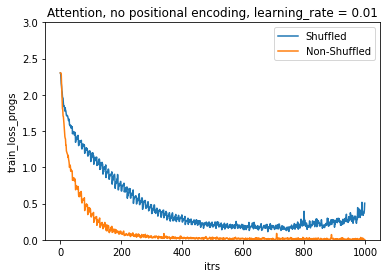

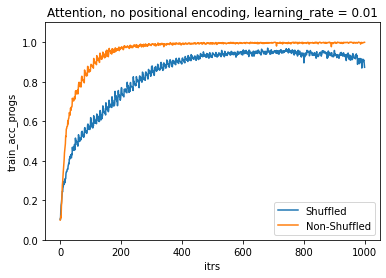

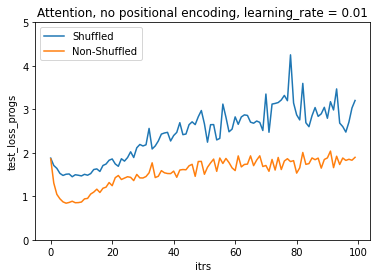

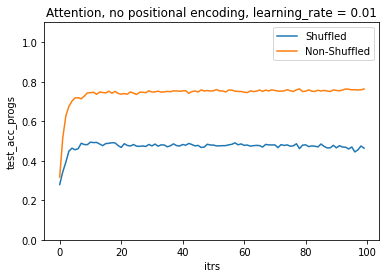

model_True_test_losses [3.21698040263668]
model_False_test_losses [1.8926814430078882]


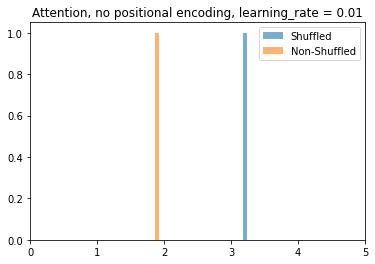

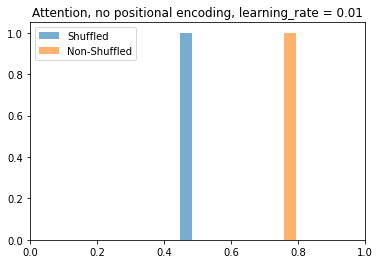

In [2]:
importlib.reload(utils)

def get_record(model_name, shuffled, extra = ""):
    #outdir = "/scratch/gpfs/qanguyen/renorm"
    outdir = "/gpfs/milgram/scratch60/turk-browne/an633/renorm_quench"
    test_losses = []
    test_accs = []
    lrs = []
    itrs = []
    train_loss_progs = []
    train_acc_progs = []
    testlosses_dict = []
    
    test_itrs = []
    test_loss_progs = []
    test_acc_progs = []
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*")[:1]:
        record = utils.load_file_pickle(f)
        itr, train_loss_prog = list(zip(*enumerate(record["metrics"]["train_loss_prog"])))
        if len(itr) > 500:
            test_losses.append(record["metrics"]["test_loss"])
            test_accs.append(record["metrics"]["test_accuracy"])
            itrs.extend(itr)
            train_loss_progs.extend(train_loss_prog)
            testlosses_dict.extend([record["metrics"]["test_loss"]] * len(itr))
            
        itr, train_acc_prog = list(zip(*enumerate(record["metrics"]["train_acc_prog"])))
        if len(itr) > 500:
            train_acc_progs.extend(train_acc_prog)
            
        itr, test_loss_prog = list(zip(*enumerate(record["metrics"]["test_loss_prog"])))
        test_itrs.extend(itr)
        test_loss_progs.extend(test_loss_prog)
        
        itr, test_acc_prog = list(zip(*enumerate(record["metrics"]["test_acc_prog"])))
        test_acc_progs.extend(test_acc_prog)
        
    print("Number of runs", model_name, shuffled, len(test_losses))
    train_df = pd.DataFrame.from_dict(dict(itrs = itrs, 
                                                         train_loss_progs = train_loss_progs, 
                                                         train_acc_progs = train_acc_progs,
                                                         testlosses_dict = testlosses_dict))
    test_df = pd.DataFrame.from_dict(dict(itrs = test_itrs, 
                                                         test_loss_progs = test_loss_progs, 
                                                         test_acc_progs = test_acc_progs))
    return test_losses, test_accs, lrs, train_df, test_df
    
    
def plot(model_name, title, extra=""):
    model_True_test_losses, model_True_test_accs, _, shuffletrainloss, shuffletestloss  = get_record(model_name = model_name, shuffled = "True", extra = extra)
    model_False_test_losses, model_False_test_accs, _, non_shuffletrainloss, non_shuffletestloss = get_record(model_name = model_name, shuffled = "False", extra = extra)
    model_True_test_losses = [i for i in model_True_test_losses if not np.isnan(i)]
    
    #model_True_test_losses = [i for i in model_True_test_losses if i < np.sort(model_True_test_losses)[-1]]
    #model_False_test_losses = [i for i in model_False_test_losses if i < np.sort(model_False_test_losses)[-1]]
    print(model_True_test_losses, len(model_True_test_losses))
    print(model_False_test_losses, len(model_False_test_losses))

    sns.lineplot(x = "itrs", y="train_loss_progs", data=shuffletrainloss, label="Shuffled")
    sns.lineplot(x = "itrs", y="train_loss_progs", data=non_shuffletrainloss, label="Non-Shuffled")
    plt.legend()
    plt.ylim(0, 3)
    plt.title(title)
    plt.show()
    
    sns.lineplot(x = "itrs", y="train_acc_progs", data=shuffletrainloss, label="Shuffled")
    sns.lineplot(x = "itrs", y="train_acc_progs", data=non_shuffletrainloss, label="Non-Shuffled")
    plt.legend()
    plt.ylim(0, 1.1)
    plt.title(title)
    plt.show()
                                     
    sns.lineplot(x = "itrs", y="test_loss_progs", data=shuffletestloss, label="Shuffled")
    sns.lineplot(x = "itrs", y="test_loss_progs", data=non_shuffletestloss, label="Non-Shuffled")
    plt.legend()
    plt.ylim(0, 5)
    plt.title(title)
    plt.show()
    
    sns.lineplot(x = "itrs", y="test_acc_progs", data=shuffletestloss, label="Shuffled")
    sns.lineplot(x = "itrs", y="test_acc_progs", data=non_shuffletestloss, label="Non-Shuffled")
    plt.legend()
    plt.ylim(0, 1.1)
    plt.title(title)
    plt.show()
    
    print("model_True_test_losses", model_True_test_losses)
    print("model_False_test_losses", model_False_test_losses)
    plt.hist(model_True_test_losses, bins=np.linspace(0, 5, 100), alpha=0.6, label="Shuffled")
    plt.hist(model_False_test_losses, bins=np.linspace(0, 5, 100), alpha=0.6, label="Non-Shuffled")
    plt.xlim(0, 5)
    plt.title(title)
    plt.legend()
    plt.show()
    

    plt.hist(model_True_test_accs, bins=np.linspace(0, 1, 30), alpha=0.6, label="Shuffled")
    plt.hist(model_False_test_accs, bins=np.linspace(0, 1, 30), alpha=0.6, label="Non-Shuffled")
    plt.xlim(0, 1)
    plt.title(title)
    plt.legend()
    plt.show()

# plot("attn_no_pe", title = "Attention, no positional encoding, learning_rate = 0.001", extra="lr_0.001")

plot("alexnet", title = "Attention, no positional encoding, learning_rate = 0.01", extra="lr_0.01")

# plot("vgg11", title = "VGG, learning_rate = 0.001", extra="lr_0.001")

# plot("vgg11", title = "VGG, learning_rate = 0.01", extra="lr_0.01")

# plot("attn_no_pe", title = "Attention, no positional encoding, learning_rate = 0.001", extra="lr_0.001")

# plot("attn_no_pe", title = "Attention, no positional encoding")

# plot("cnn_chan_1-16", title = "CNN, 1/16 channels, learning_rate = 0.001", extra="lr_0.001")

# plot("cnn_chan_1-16", title = "CNN, 1/16 channels, learning_rate = 0.01", extra="lr_0.01")

# plot("cnn_chan_1-1", title = "CNN, 1/1 channels, learning_rate = 0.001", extra="lr_0.001")

# plot("cnn_chan_1-1", title = "CNN, 1/1 channels, learning_rate = 0.01", extra="lr_0.01")

# plot("cnn_chan_1-16", title = "CNN, 1/16 channels")

# plot("mlp", title = "MLP", extra="lr_0.001")

# plot("mlp", title = "MLP", extra="lr_0.01")


## Holding the shuffle permutation fixed

[[[0.4496173  0.52663434 0.47668734]
  [0.54987353 0.55575544 0.5160403 ]
  [0.49554032 0.5608506  0.5492583 ]
  [0.5134214  0.52657974 0.4315286 ]
  [0.43549526 0.510604   0.5265976 ]
  [0.55574983 0.48856792 0.45850074]
  [0.5135425  0.48764232 0.46054152]
  [0.46217045 0.52114636 0.46102372]
  [0.5325329  0.5497944  0.5467843 ]
  [0.5329117  0.5293136  0.46599266]
  [0.504152   0.5038543  0.47570086]]

 [[0.5091302  0.50606674 0.55340743]
  [0.5502989  0.5440201  0.5395487 ]
  [0.53897417 0.5202846  0.4036138 ]
  [0.5355207  0.44556168 0.5176998 ]
  [0.48846766 0.5544489  0.5427135 ]
  [0.5677274  0.53840053 0.47507572]
  [0.45627674 0.4762116  0.4716182 ]
  [0.47201705 0.46289653 0.49129343]
  [0.54394644 0.5046541  0.46903798]
  [0.5069712  0.5397295  0.5476844 ]
  [0.49559498 0.5559115  0.5402565 ]]

 [[0.5109227  0.5133579  0.49632737]
  [0.481006   0.4987156  0.5582062 ]
  [0.5232589  0.5462615  0.4835016 ]
  [0.41105163 0.46870846 0.48534986]
  [0.5309055  0.5225289  0.5383739

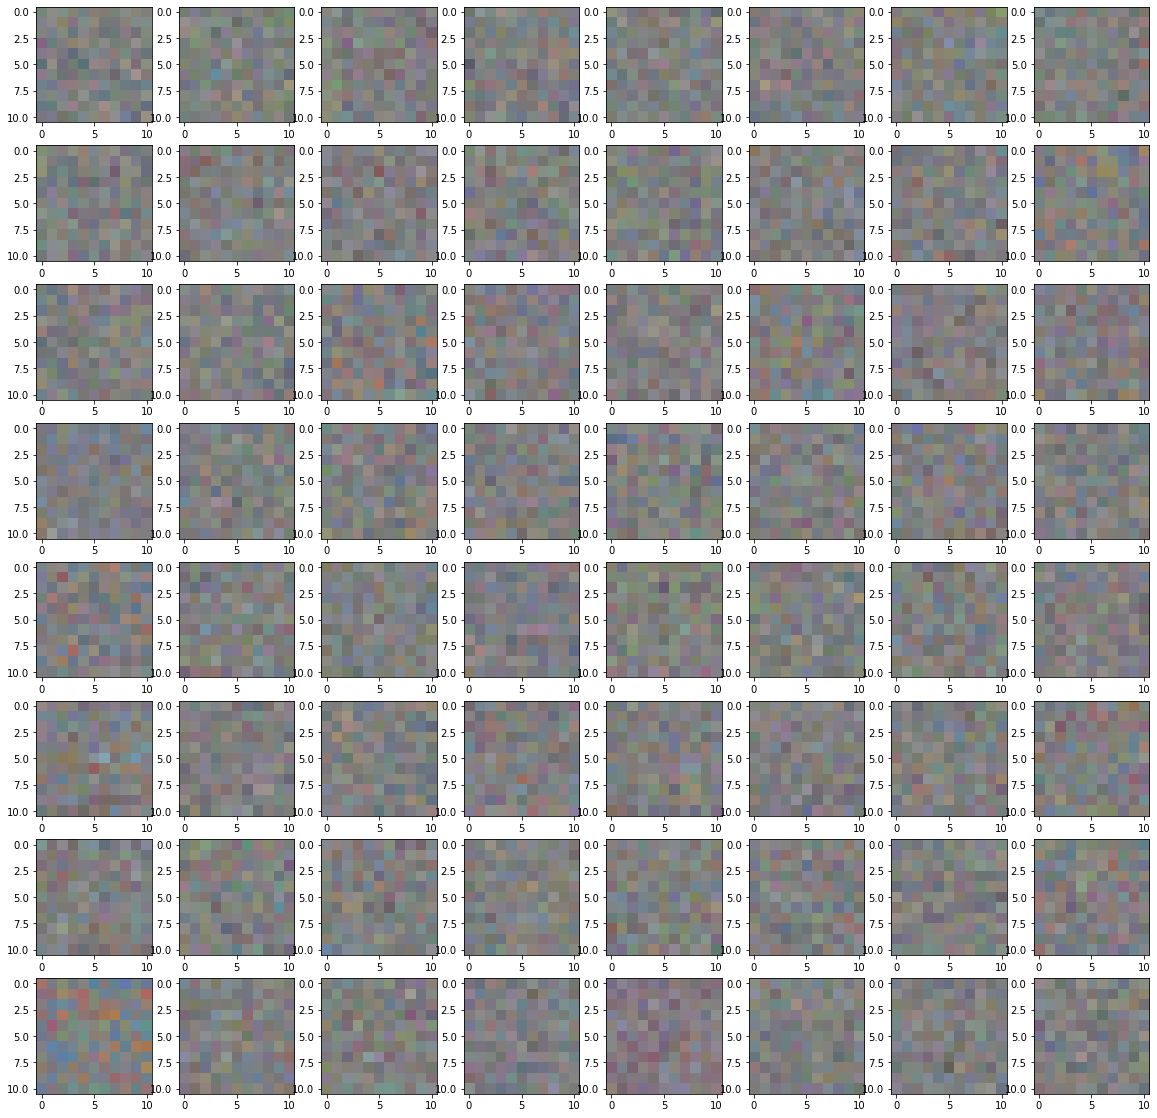

NameError: name 'model' is not defined

In [16]:
importlib.reload(utils)

def get_record(model_name, shuffled, extra = ""):
    #outdir = "/scratch/gpfs/qanguyen/renorm"
    outdir = "/gpfs/milgram/scratch60/turk-browne/an633/renorm_quench"
    
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*")[:2]:
        record = utils.load_file_pickle(f)
        m = record["model"]
        param_dict = {n:p for n, p in m}

        param_dict['alexnet.features.0.weight'] = param_dict['alexnet.features.0.weight'].permute(0, 2, 3, 1) * 0.5 + 0.5 
        plt.figure(figsize=(20, 20))
        for _ in range(64):
            plt.subplot(8, 8, _+1)
            v = param_dict['alexnet.features.0.weight'][_].detach().cpu().numpy()
            if _ == 0:
                print(v)
            plt.imshow(v)
            #pars[_].append(v)
        plt.show()
        
        print(model)
        break
get_record("alexnet", shuffled=True)

# Average the filters for different quenched transformations 


In [ ]:
importlib.reload(utils)

def get_record(model_name, shuffled, extra = ""):
    outdir = "/scratch/gpfs/qanguyen/renorm"
    import warnings
    warnings.filterwarnings("ignore")
    pars = defaultdict(list)
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*")[:200]:
        record = utils.load_file_pickle(f)
        m = record["model"]
        param_dict = {n:p for n, p in m}
        param_dict['conv1.weight'] = param_dict['conv1.weight'].permute(0, 2, 3, 1) * 0.5 + 0.5 
        #plt.figure(figsize=(10,5))
        for _ in range(6):
            #plt.subplot(1, 6, _+1)
            v = param_dict['conv1.weight'][_].detach().cpu().numpy()
            #plt.imshow(v)
            pars[_].append(v)
        #print(param_dict['conv1.weight'])
        #plt.show()
    plt.figure(figsize=(10,5))
    i = 1
    stds = []
    for _, convs in pars.items():
        plt.subplot(1, 6, i)
        m = torch.tensor(convs).mean(dim=0)
        s = torch.tensor(convs).std(dim=0)
        #print(m)
        plt.imshow(m,vmin=0,vmax=1)
        i += 1
        stds.extend(s.numpy().ravel())
    plt.show()
    plt.hist(stds)
    plt.xlim(0.1, 0.9)
    plt.show()

get_record(model_name = "cnn", shuffled=True)
get_record(model_name = "cnn", shuffled=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

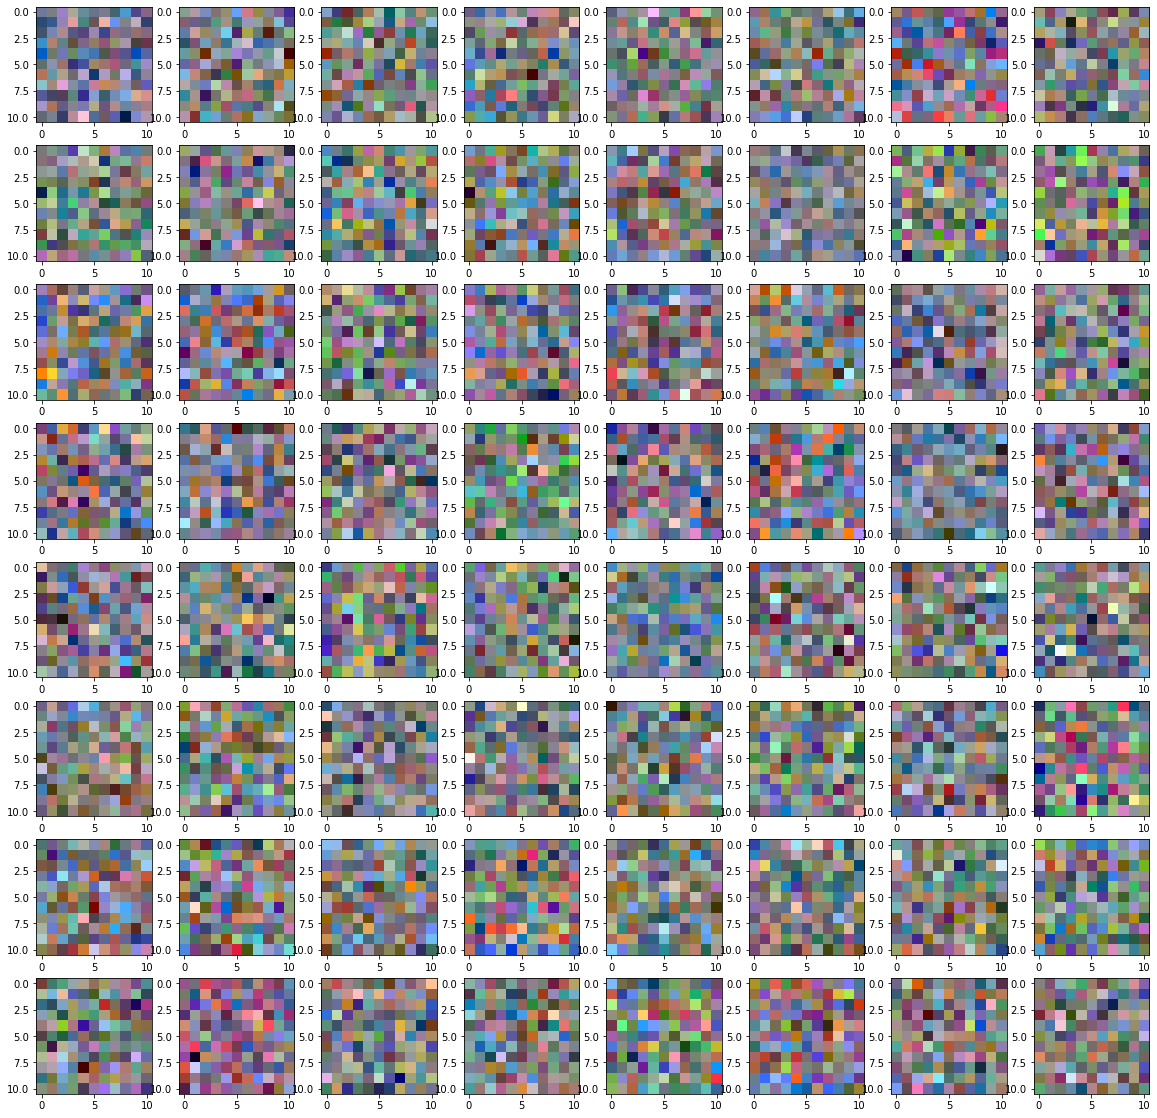

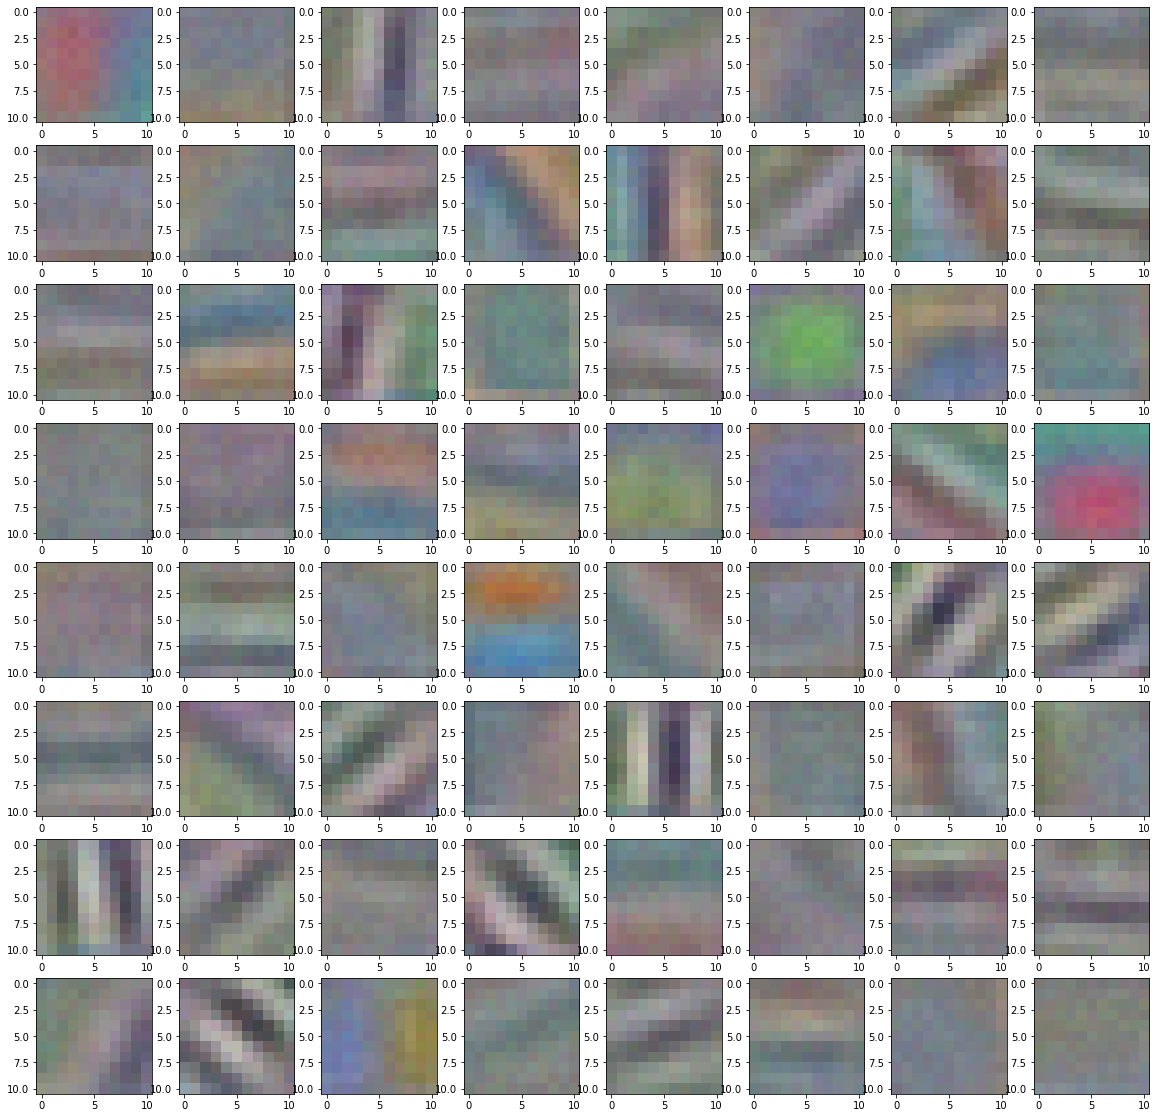

In [66]:
importlib.reload(utils)
def get_record(model_name, shuffled, extra = ""):
    outdir = "/scratch/gpfs/qanguyen/renorm"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*")[:1]:
        record = utils.load_file_pickle(f)
        m = record["model"]
        param_dict = {n:p for n, p in m}

        param_dict['alexnet.features.0.weight'] = param_dict['alexnet.features.0.weight'].permute(0, 2, 3, 1) * 0.5 + 0.5 
        plt.figure(figsize=(20, 20))
        for _ in range(64):
            plt.subplot(8, 8, _+1)
            v = param_dict['alexnet.features.0.weight'][_].detach().cpu().numpy()
            plt.imshow(v)
            pars[_].append(v)
        plt.show()
import warnings

get_record(model_name = "alexnet", shuffled=True)
get_record(model_name = "alexnet", shuffled=False)

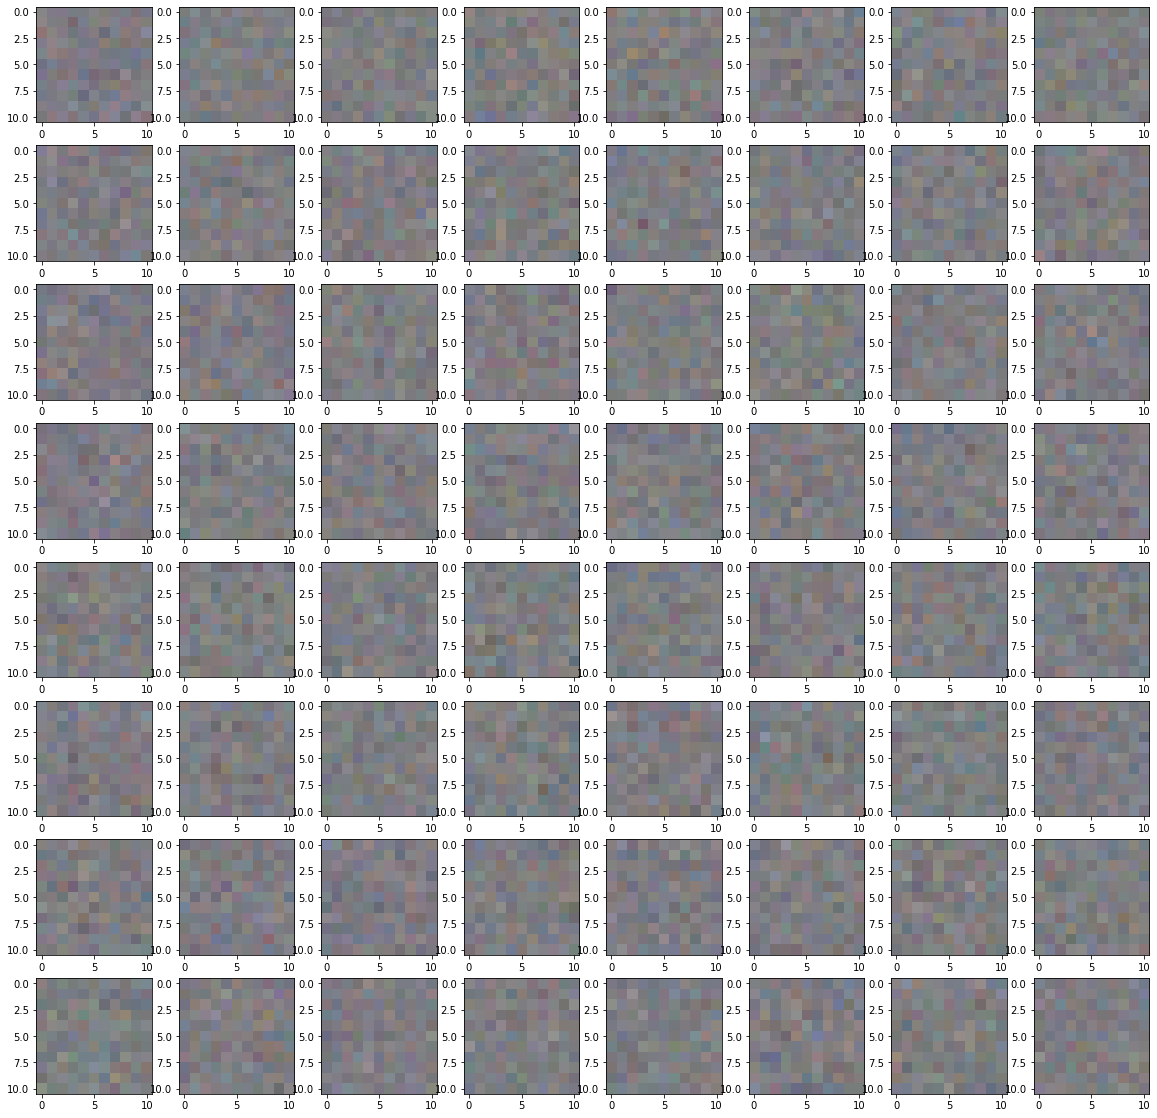

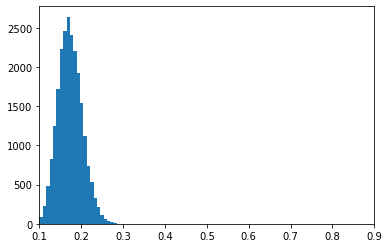

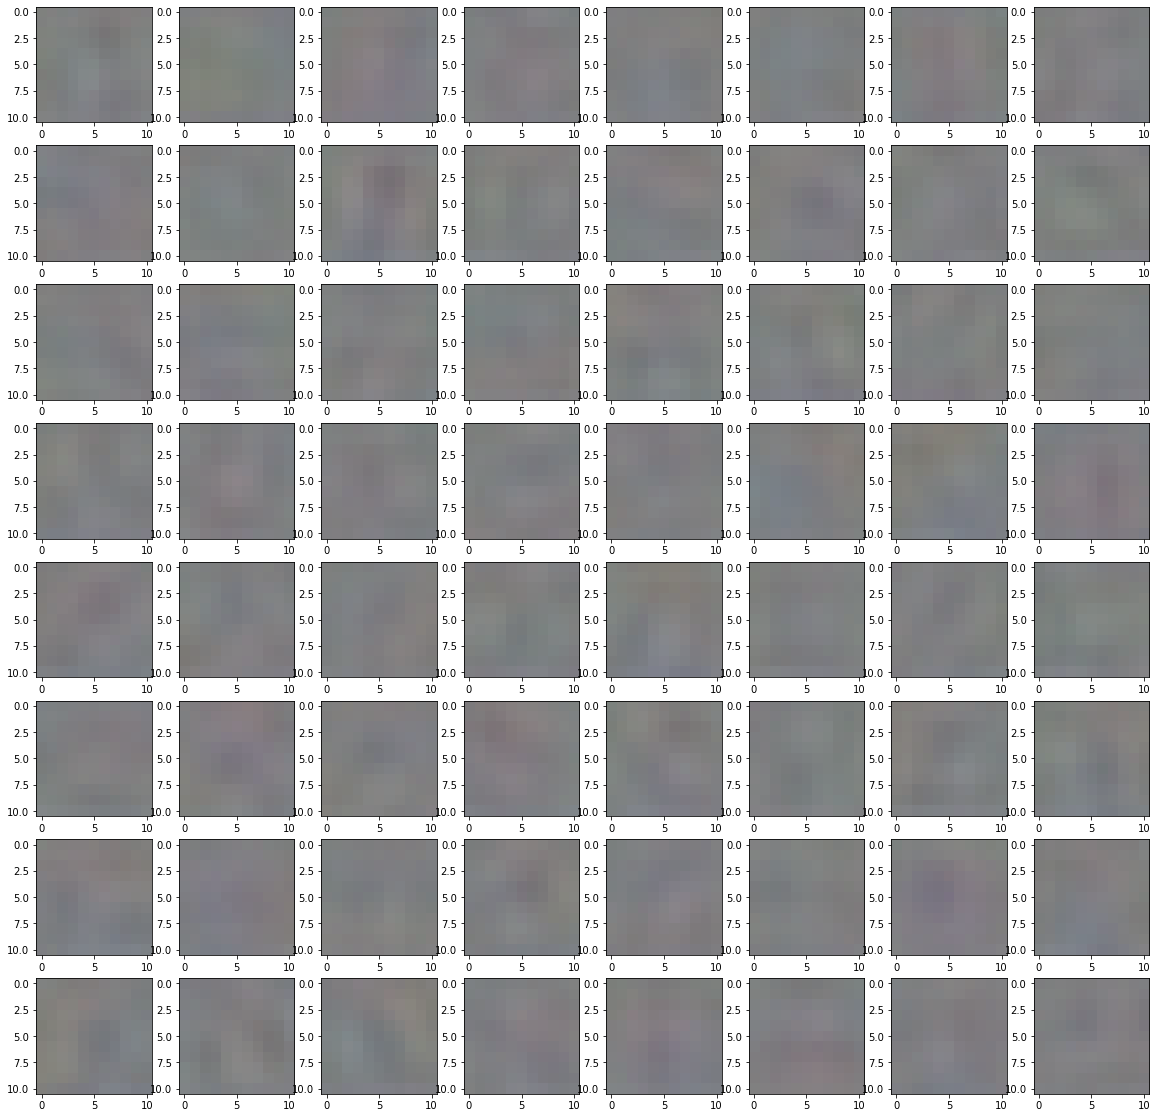

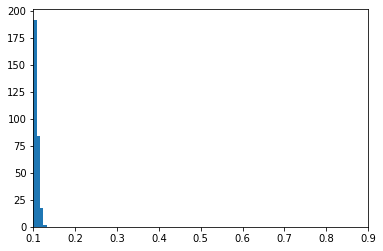

In [72]:
def get_record(model_name, shuffled, extra = ""):
    outdir = "/scratch/gpfs/qanguyen/renorm"
    import warnings
    warnings.filterwarnings("ignore")
    pars = defaultdict(list)
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*")[:200]:
        record = utils.load_file_pickle(f)
        m = record["model"]
        param_dict = {n:p for n, p in m}

        param_dict['alexnet.features.0.weight'] = param_dict['alexnet.features.0.weight'].permute(0, 2, 3, 1) * 0.5 + 0.5 
        for _ in range(64):
            v = param_dict['alexnet.features.0.weight'][_].detach().cpu().numpy()
            pars[_].append(v)
    plt.figure(figsize=(20,20))
    i = 1
    stds = []
    for _, convs in pars.items():
        plt.subplot(8, 8, i)
        m = torch.tensor(convs).mean(dim=0)
        s = torch.tensor(convs).std(dim=0)
        #print(m)
        plt.imshow(m,vmin=0,vmax=1)
        i += 1
        stds.extend(s.numpy().ravel())
    plt.show()
    plt.hist(stds,bins=np.linspace(0.1,0.9,100))
    plt.xlim(0.1, 0.9)
    plt.show()

get_record(model_name = "alexnet", shuffled=True)
get_record(model_name = "alexnet", shuffled=False)

# Hold quenched transform fixed and run multiple runs on that transformation

In [6]:
importlib.reload(utils)
def get_record(model_name, shuffled, extra = ""):
    outdir = "/scratch/gpfs/qanguyen/renorm"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*"):
        record = utils.load_file_pickle(f)
        print(record)
        m = record["model"]
        param_dict = {n:p for n, p in m}

        param_dict['alexnet.features.0.weight'] = param_dict['alexnet.features.0.weight'].permute(0, 2, 3, 1) * 0.5 + 0.5 
        plt.figure(figsize=(20, 20))
        for _ in range(64):
            plt.subplot(8, 8, _+1)
            v = param_dict['alexnet.features.0.weight'][_].detach().cpu().numpy()
            plt.imshow(v)
            pars[_].append(v)
        plt.show()
import warnings

get_record(model_name = "alexnet", shuffled=True)
get_record(model_name = "alexnet", shuffled=False)a

SyntaxError: invalid syntax (3481618575.py, line 23)

# Polynomial Regression

## Models (MLP_small, resnetsmall)

/scratch/gpfs/qanguyen/poly_learncurve/mlp_small_order_3_numinputs_14_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1664751062.974683.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_learncurve/mlp_small_order_3_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1664748096.510145.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_learncurve/mlp_small_order_3_numinputs_14_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1664745074.98025.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_learncurve/mlp_small_order_3_numinputs_22_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1664745108.597752.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_learncurve/mlp_small_order_3_numinputs_26_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1664745084.080042.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_learncurve/mlp_small_order_3_numinputs_18_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1664748040.435527.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_learncurve/mlp_small_order

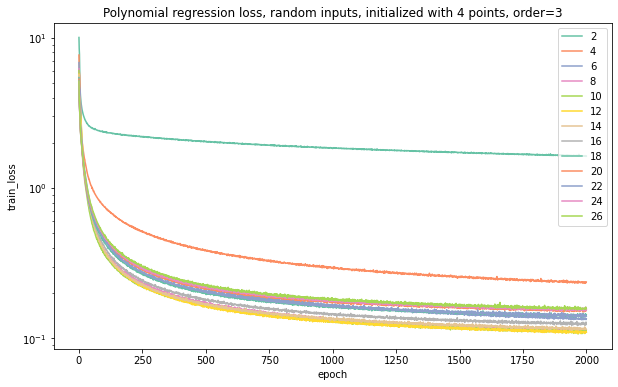

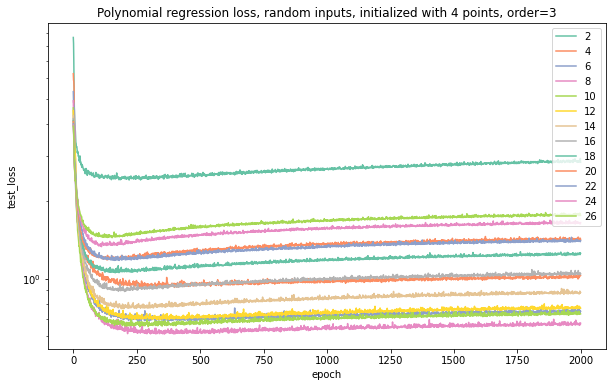

In [8]:
importlib.reload(utils)
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_inputs_kept_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        
        pars["train_loss"].extend(record["metrics"]["train_loss_prog"])
        pars["test_loss"].extend(record["metrics"]["test_loss_prog"])
        pars["epoch"].extend(range(len(record["metrics"]["train_loss_prog"])))
        pars["policy"].extend([(record["data_params"]["num_inputs"])] * len(record["metrics"]["train_loss_prog"]))
        print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="train_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="test_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1)
    plt.title(title)
    plt.show()
    
import warnings

# get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1", order_list=[2,4,8,12,80])
get_record(model_name = "mlp_small", order = 3, input_strategy_list=["random"], 
           is_online=False, title = "Polynomial regression loss, random inputs, initialized with 4 points, order=3", 
           num_inputs_list=np.arange(2, 32, 2), 
           outdir = "/scratch/gpfs/qanguyen/poly_learncurve")


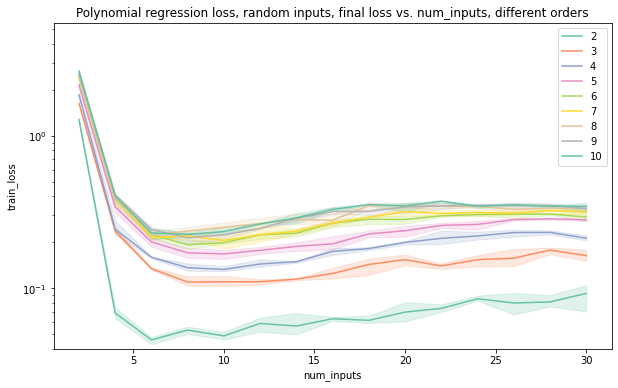

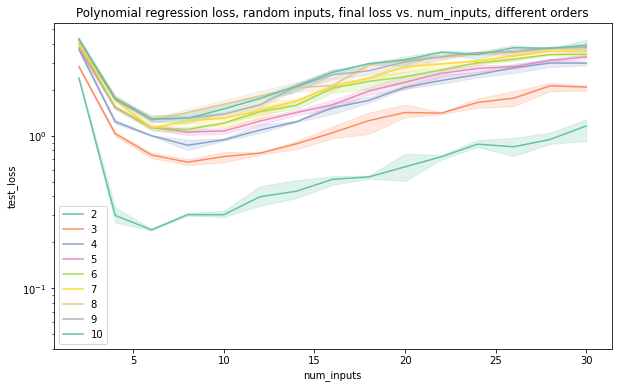

In [28]:
importlib.reload(utils)
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_inputs_kept_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        
        pars["train_loss"].append(record["metrics"]["train_loss_prog"][-1])
        pars["test_loss"].append(record["metrics"]["test_loss_prog"][-1])
        pars["num_inputs"].append(record["data_params"]["num_inputs"])
        pars["order"].append(record["data_params"]["order"])
        #print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "num_inputs", y="train_loss", hue="order",  palette = "Set2", data=pars )
    ax.set(yscale="log")
    plt.legend()
    plt.ylim(4e-2, 5.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "num_inputs", y="test_loss", hue="order", palette = "Set2", data=pars )
    ax.set(yscale="log")
    plt.legend()
    plt.ylim(4e-2, 5.5)
    plt.title(title)
    plt.show()
    
import warnings

# get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1", order_list=[2,4,8,12,80])
get_record(model_name = "mlp_small", order = "*", input_strategy_list=["random"], 
           is_online=False, title = "Polynomial regression loss, random inputs, final loss vs. num_inputs, different orders", 
           num_inputs_list=np.arange(2, 32, 2), 
           outdir = "/scratch/gpfs/qanguyen/poly_learncurve")


### Plot epochs vs. loss

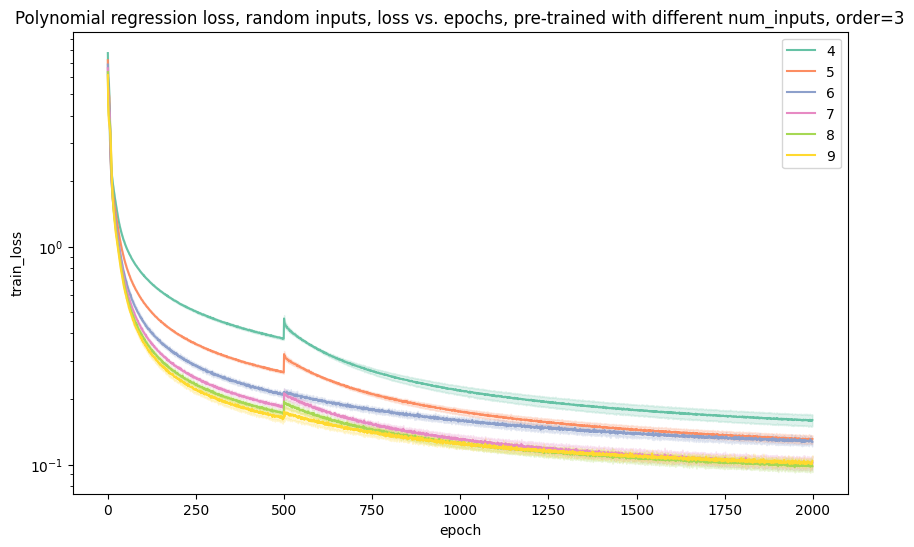

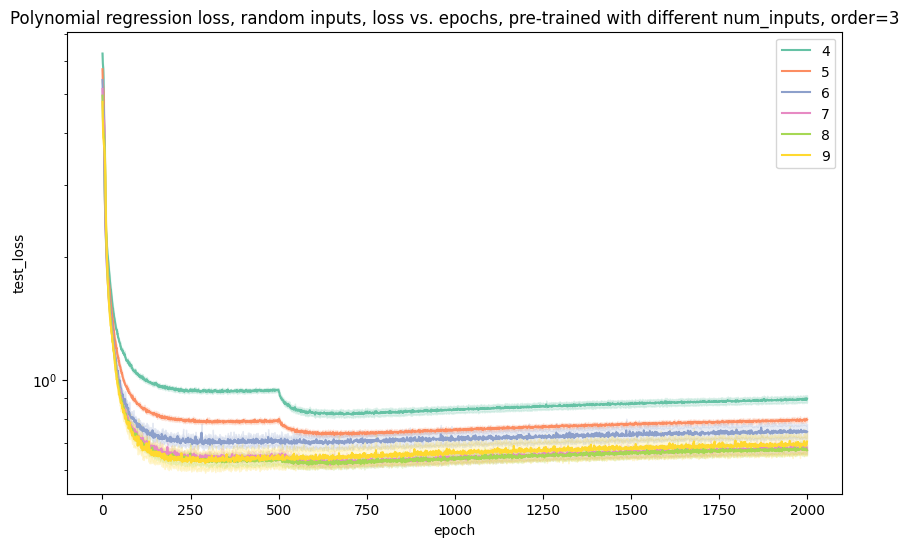

In [21]:
importlib.reload(utils)
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_inputs_kept_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        
         
        #pars["num_inputs"].append(record["data_params"]["num_inputs"])
        # pars["num_inputs_kept"].append(record["train_params"]["num_inputs_kept"])
        
        pars["train_loss"].extend(record["metrics"]["train_loss_prog"])
        pars["test_loss"].extend(record["metrics"]["test_loss_prog"])
        pars["epoch"].extend(range(len(record["metrics"]["train_loss_prog"])))
        pars["policy"].extend([(record["train_params"]["num_inputs_kept"])] * len(record["metrics"]["train_loss_prog"]))
        #print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="train_loss", hue = "policy", palette = "Set2", data=pars )
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="test_loss", hue = "policy", palette = "Set2", data=pars )
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1)
    plt.title(title)
    plt.show()
    
import warnings

# get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1", order_list=[2,4,8,12,80])
get_record(model_name = "mlp_small_silence", order = "*", input_strategy_list=["random"], 
           is_online=False, title = "Polynomial regression loss, random inputs, loss vs. epochs, pre-trained with different num_inputs, order=3", 
           num_inputs_list=np.arange(2, 32, 2), 
           outdir =  "./poly_freeze")

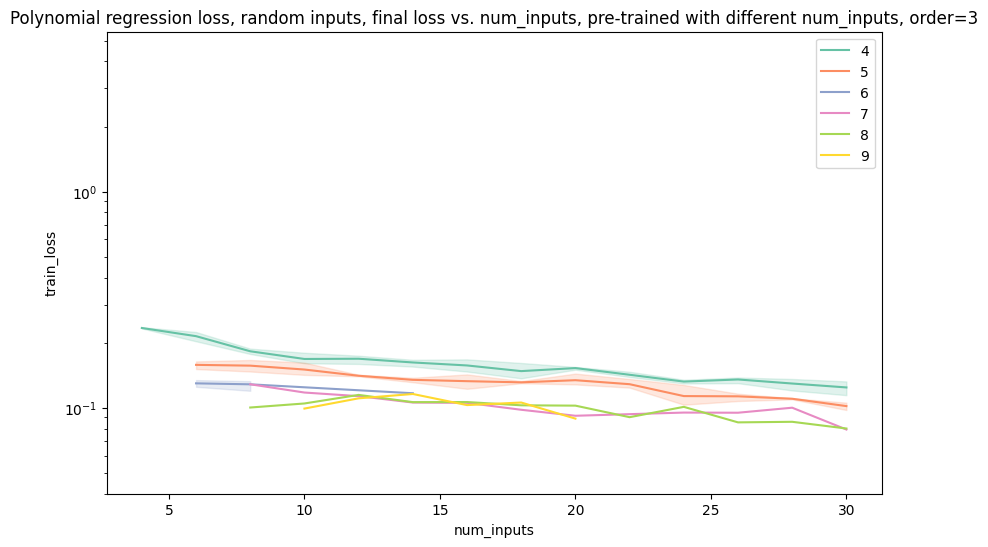

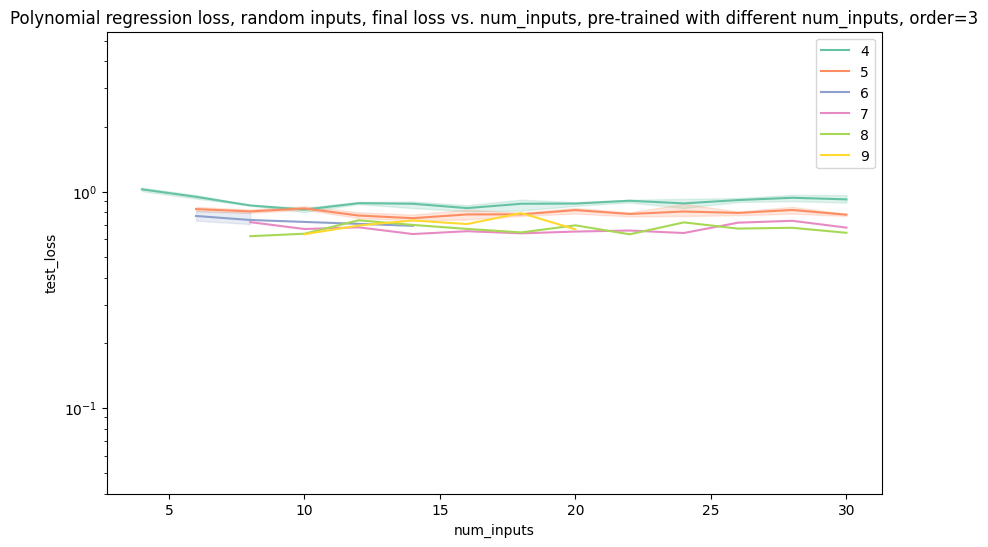

In [13]:
importlib.reload(utils)
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_inputs_kept_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        
        pars["train_loss"].append(record["metrics"]["train_loss_prog"][-1])
        pars["test_loss"].append(record["metrics"]["test_loss_prog"][-1])
        pars["num_inputs"].append(record["data_params"]["num_inputs"])
        pars["num_inputs_kept"].append(record["train_params"]["num_inputs_kept"])
        #print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "num_inputs", y="train_loss", hue="num_inputs_kept",  palette = "Set2", data=pars )
    ax.set(yscale="log")
    plt.legend()
    plt.ylim(4e-2, 5.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "num_inputs", y="test_loss", hue="num_inputs_kept", palette = "Set2", data=pars )
    ax.set(yscale="log")
    plt.legend()
    plt.ylim(4e-2, 5.5)
    plt.title(title)
    plt.show()
    
import warnings

# get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1", order_list=[2,4,8,12,80])
get_record(model_name = "mlp_small_silence", order = "*", input_strategy_list=["random"], 
           is_online=False, title = "Polynomial regression loss, random inputs, final loss vs. num_inputs, pre-trained with different num_inputs, order=3", 
           num_inputs_list=np.arange(2, 32, 2), 
           outdir = "./poly_freeze")

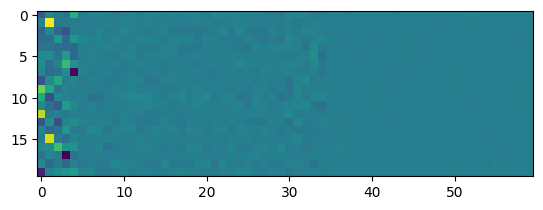

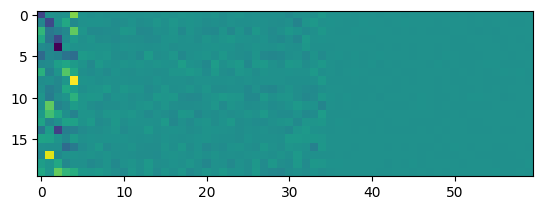

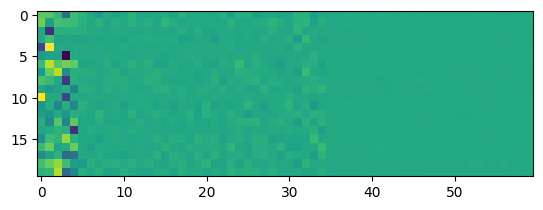

defaultdict(<class 'list'>, {'train_loss': [0.09748317609179993, 0.10538911804252742, 0.10198916012079132], 'test_loss': [0.7887977319104331, 0.7839827975448297, 0.7713834251068077], 'num_inputs': [30, 30, 30], 'num_inputs_kept': [5, 5, 5]})


In [17]:
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_inputs_kept_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        if record["train_params"]["num_inputs_kept"] not in num_inputs_kept_list:
             continue
        pars["train_loss"].append(record["metrics"]["train_loss_prog"][-1])
        pars["test_loss"].append(record["metrics"]["test_loss_prog"][-1])
        pars["num_inputs"].append(record["data_params"]["num_inputs"])
        pars["num_inputs_kept"].append(record["train_params"]["num_inputs_kept"])
        img = record["model"].fc1.weight.cpu().detach().numpy()[:20]
        #print(img[:5])
        plt.imshow(img)
        plt.show()
    print(pars)
# get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1", order_list=[2,4,8,12,80])
get_record(model_name = "mlp_small_silence", order = "*", input_strategy_list=["random"], 
           is_online=False, title = "Polynomial regression loss, random inputs, final loss vs. num_inputs, pre-trained with different num_inputs, order=3", 
           num_inputs_kept_list = [5],
           num_inputs_list=[30], 
           outdir = "./poly_freeze")

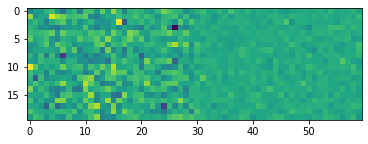

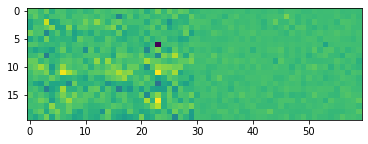

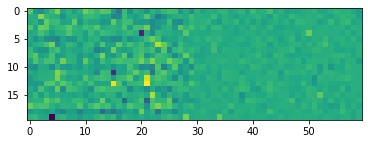

defaultdict(<class 'list'>, {'train_loss': [0.1784662097996595, 0.15113789842901182, 0.1611216950933544], 'test_loss': [2.137012933589974, 1.9713516545539, 2.1378392528514474], 'num_inputs': [30, 30, 30]})


In [47]:
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_inputs_kept_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        
        pars["train_loss"].append(record["metrics"]["train_loss_prog"][-1])
        pars["test_loss"].append(record["metrics"]["test_loss_prog"][-1])
        pars["num_inputs"].append(record["data_params"]["num_inputs"])
        img = record["model"].fc1.weight.cpu().detach().numpy()[:20]
        #print(img[:5])
        plt.imshow(img)
        plt.show()
    print(pars)
# get_record(model_name = "mlp_small", order = 1, is_online=False, title = "Polynomial regression loss, order=1", order_list=[2,4,8,12,80])
get_record(model_name = "mlp_small", order = "3", input_strategy_list=["random"], 
           is_online=False, title = "Polynomial regression loss, random inputs, final loss vs. num_inputs, pre-trained with different num_inputs, order=3", 
           num_inputs_list=[30], 
           outdir = "/scratch/gpfs/qanguyen/poly_learncurve")

## Attention

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662484172.58822.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_4_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662449731.247456.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662475501.277991.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662449760.594867.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_4_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662463919.866433.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662449730.946023.

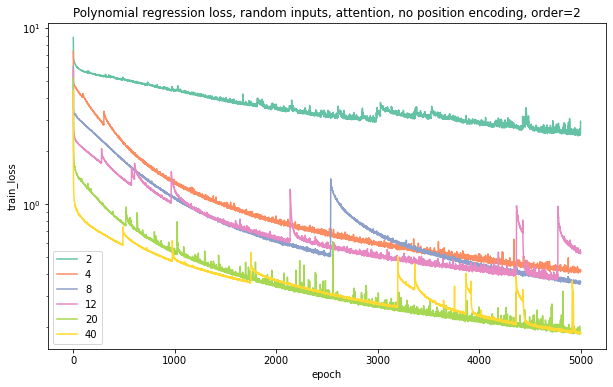

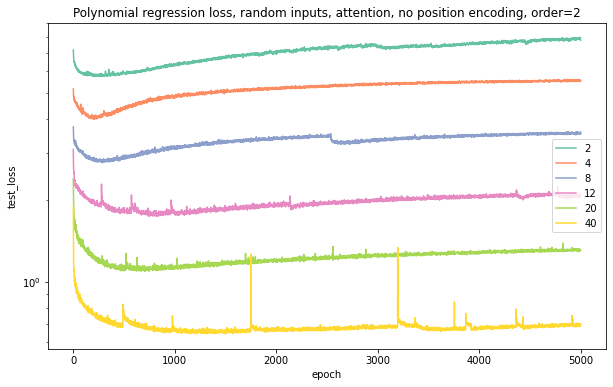

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662463467.368335.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662483453.933914.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_4_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662478645.662084.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662449700.631759.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662466470.337386.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662475811.07033

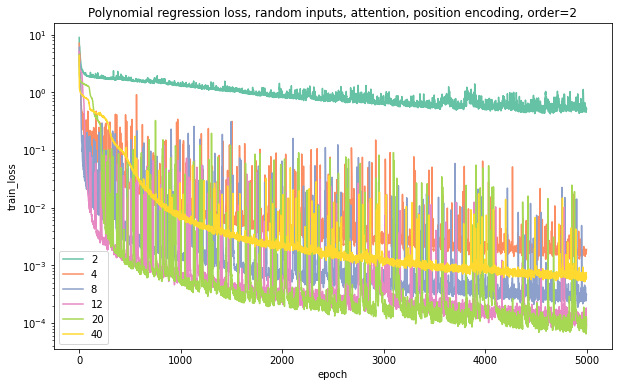

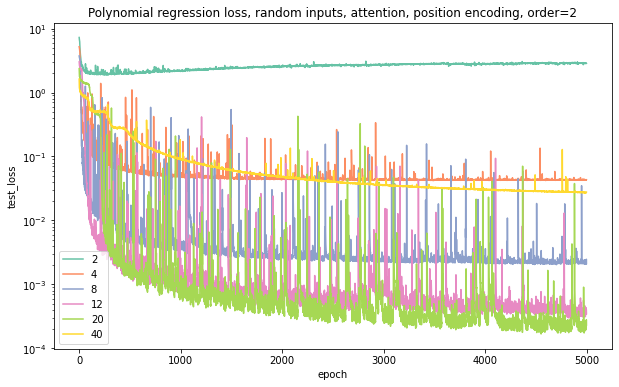

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_4_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662470398.204635.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662468451.198952.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662453450.85505.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662439086.970412.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662439117.219949.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662439086.941504.

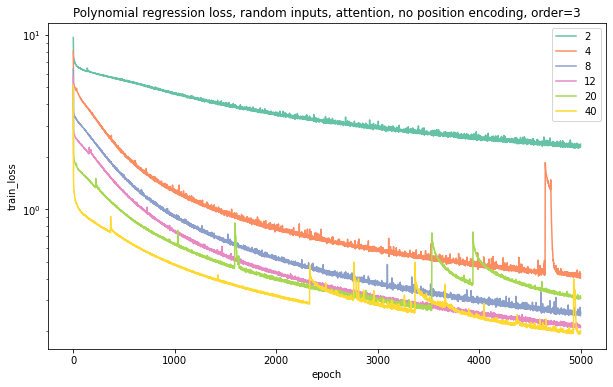

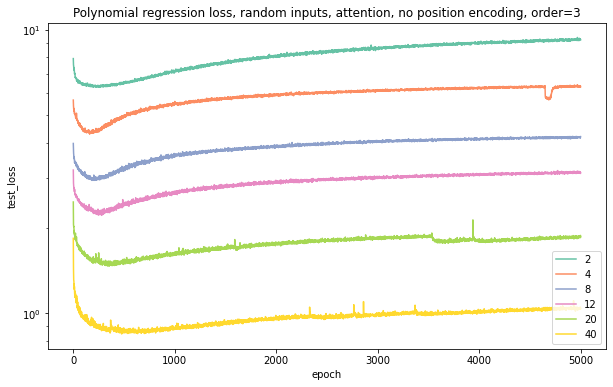

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662455856.919402.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662469898.597653.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662491107.012901.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662439147.212894.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662439177.82179.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662454326.0969

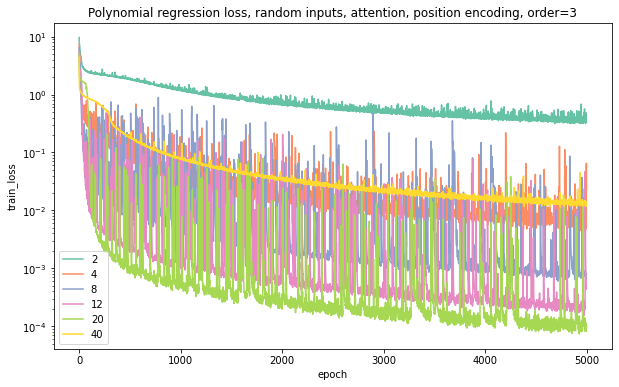

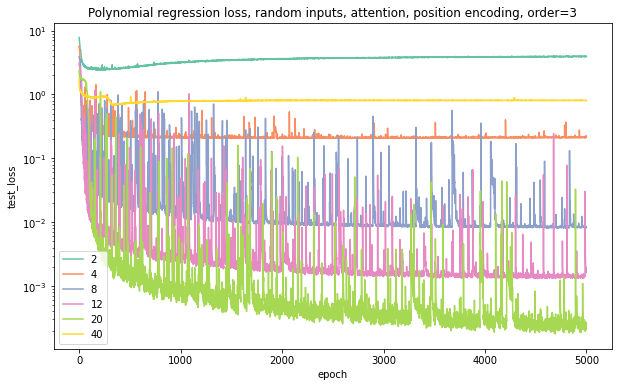

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662512242.440004.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662463446.362753.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662477598.74391.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662498051.987424.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662483164.535306.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662497825.547672.pk

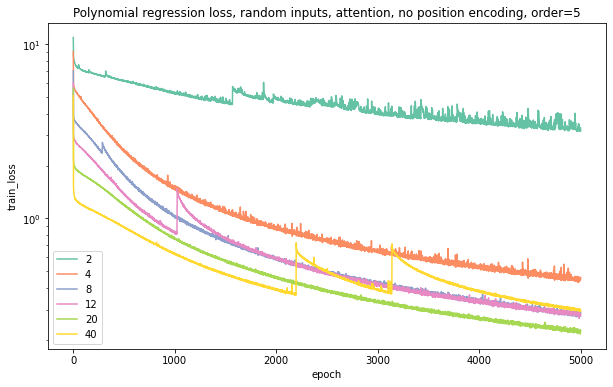

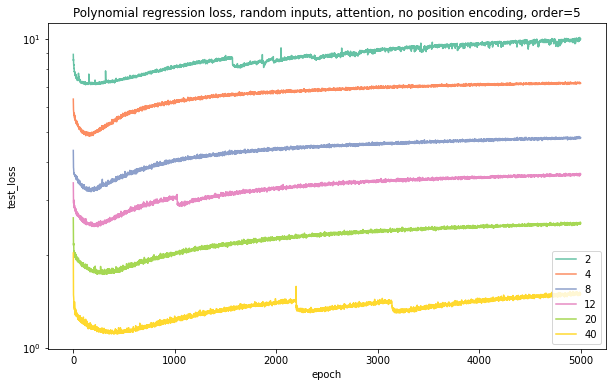

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_4_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662543792.610659.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662528542.084614.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662564597.525783.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662512211.94296.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662512242.28512.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662512272.543328.p

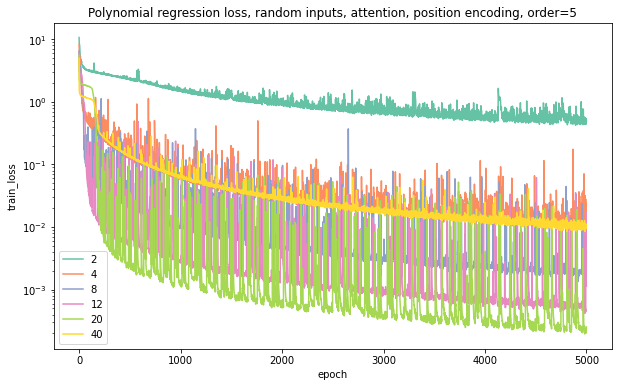

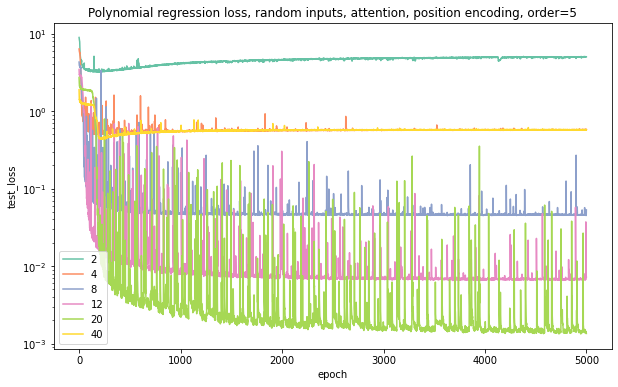

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662503755.225345.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662487127.712982.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662489646.362909.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662507438.083168.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662499703.052722.pkl noise 0.0 pe_weight 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_4_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662518344.8

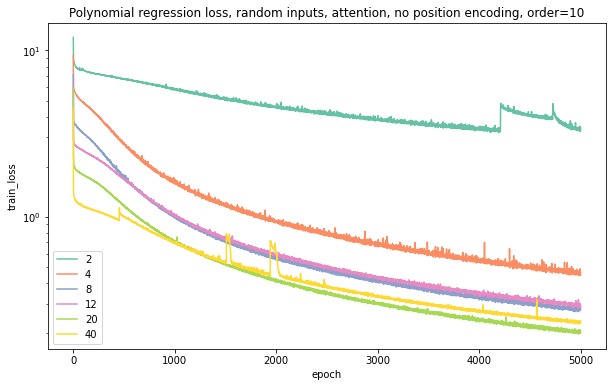

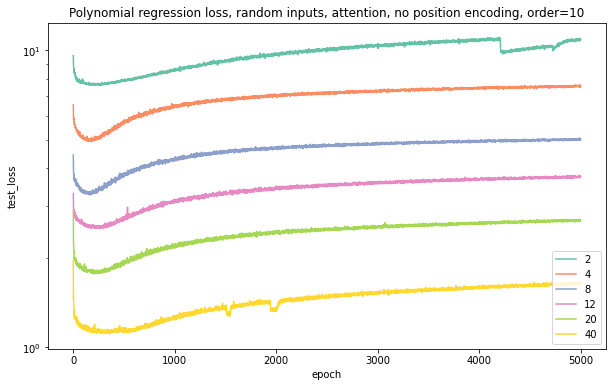

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662528040.666063.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662512272.501133.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662528724.944275.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662545093.478957.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662512303.105787.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662526742.2

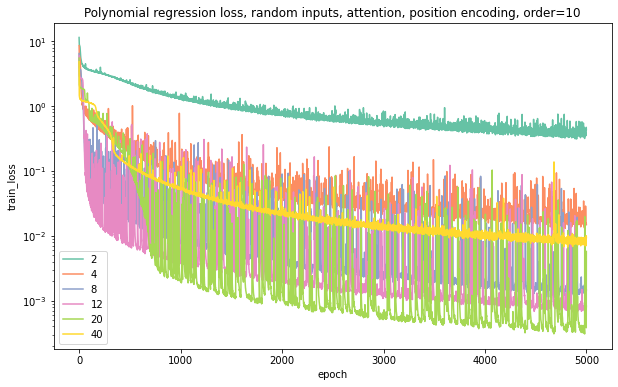

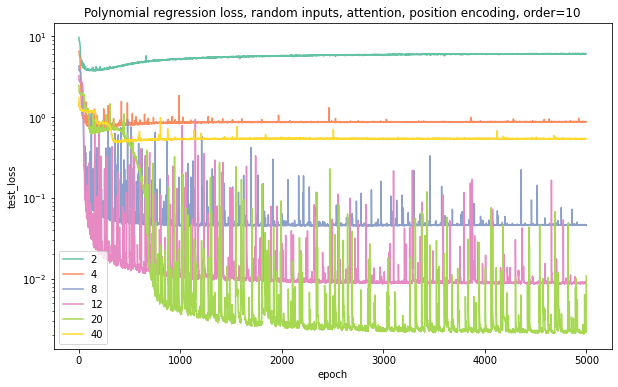

In [19]:
importlib.reload(utils)
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_examples_list = [],
               pe_weight_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_examples"] not in num_examples_list:
            continue
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        model = record["model"]
        if (model.pe_weight not in pe_weight_list):
            continue
        pars["train_loss"].extend(record["metrics"]["train_loss_prog"])
        pars["test_loss"].extend(record["metrics"]["test_loss_prog"])
        pars["epoch"].extend(range(len(record["metrics"]["train_loss_prog"])))
        pars["policy"].extend([(record["data_params"]["num_inputs"])] * len(record["metrics"]["train_loss_prog"]))
        print(f, "noise", record["data_params"]["noise"], "pe_weight", model.pe_weight)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="train_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="test_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1)
    plt.title(title)
    plt.show()
    
import warnings



get_record(model_name = "attention_small", order = 2, input_strategy_list=["random"], 
           pe_weight_list = [0.0],
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, no position encoding, order=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 2, input_strategy_list=["random"], 
           pe_weight_list = [1.0],
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, position encoding, order=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 3, input_strategy_list=["random"], 
           pe_weight_list = [0.0],
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, no position encoding, order=3", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 3, input_strategy_list=["random"], 
           pe_weight_list = [1.0],
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, position encoding, order=3", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 5, input_strategy_list=["random"], 
           pe_weight_list = [0.0],
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, no position encoding, order=5", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 5, input_strategy_list=["random"], 
           pe_weight_list = [1.0],
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, position encoding, order=5", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 10, input_strategy_list=["random"], 
           pe_weight_list = [0.0],
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, no position encoding, order=10", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 10, input_strategy_list=["random"], 
           pe_weight_list = [1.0],
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, position encoding, order=10", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662605367.98195.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_4_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662602671.078724.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_4_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662562098.92317.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_40_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662577338.536878.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662563715.982831.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_2_numinputs_20_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662570323.73

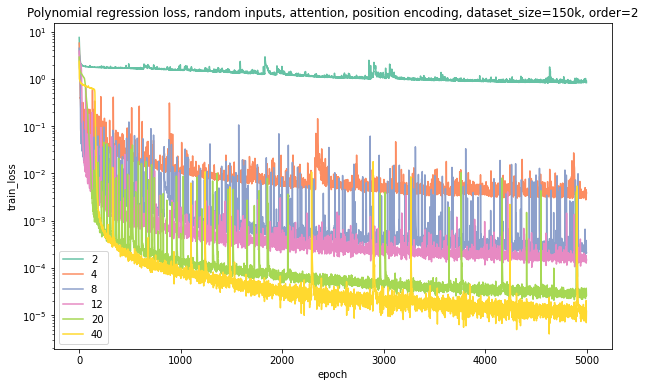

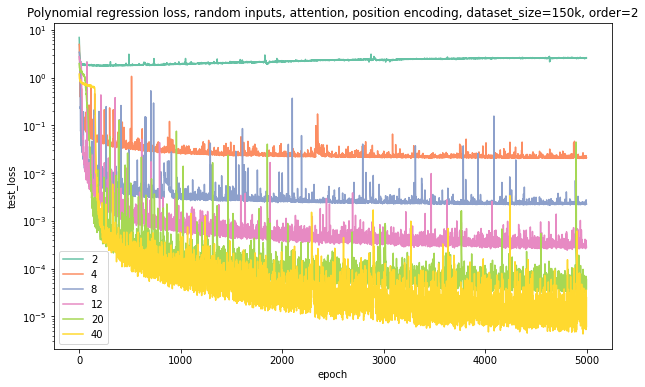

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662559203.602351.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662601434.326832.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_4_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662557631.023955.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_20_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662559595.507944.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662556667.186658.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662598624.8

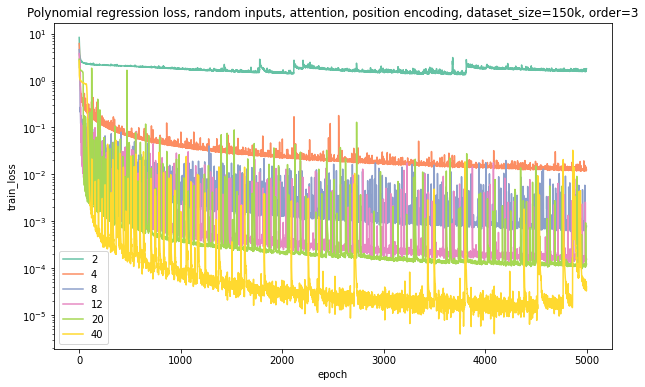

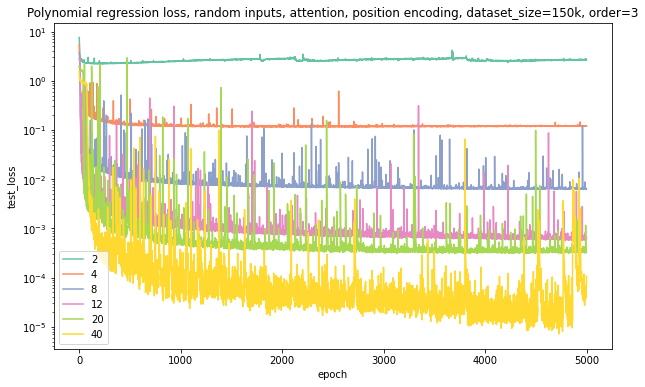

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662536972.490943.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_4_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662534446.883908.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_40_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662553845.315084.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662536038.41177.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662576170.778538.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_5_numinputs_20_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662541335.9

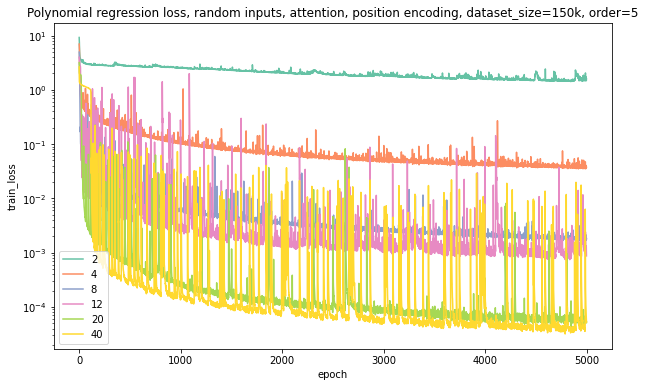

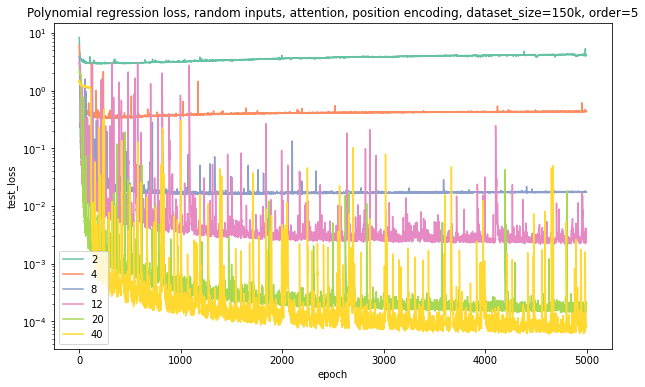

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_4_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662517180.883856.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_40_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662529505.069194.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662527238.313941.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662558495.785183.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662526938.197822.pkl noise 0.0 pe_weight 1.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_10_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_166251

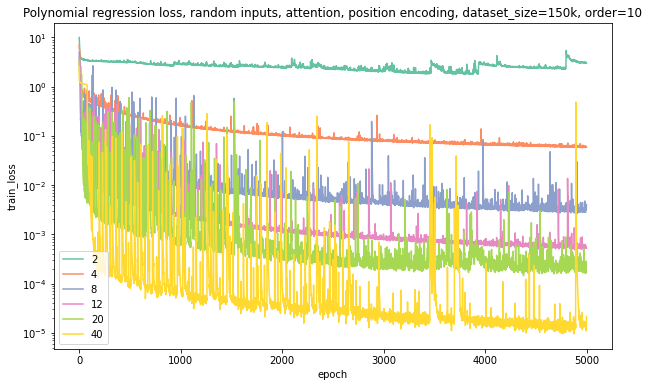

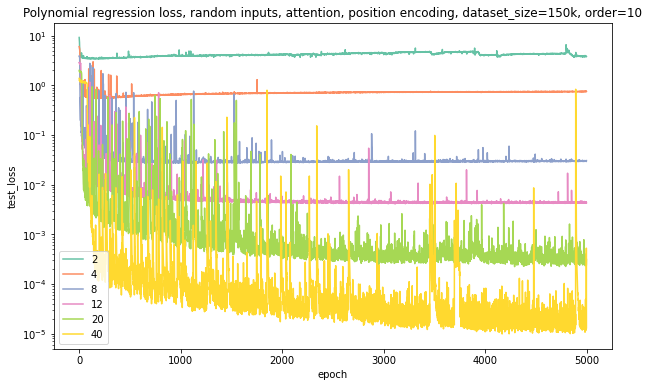

In [22]:
# get_record(model_name = "attention_small", order = 2, input_strategy_list=["random"], 
#            pe_weight_list = [0.0],
#            num_examples_list = [150000],
#            is_online=False, title = "Polynomial regression loss, random inputs, attention, no position encoding, order=2", 
#            num_inputs_list=[2, 4,8,12,20, 40, 60], 
#            outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 2, input_strategy_list=["random"], 
           pe_weight_list = [1.0],
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, position encoding, dataset_size=150k, order=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
# get_record(model_name = "attention_small", order = 3, input_strategy_list=["random"], 
#            pe_weight_list = [0.0],
#            num_examples_list = [150000],
#            is_online=False, title = "Polynomial regression loss, random inputs, attention, no position encoding, order=3", 
#            num_inputs_list=[2, 4,8,12,20, 40, 60], 
#            outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 3, input_strategy_list=["random"], 
           pe_weight_list = [1.0],
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, position encoding, dataset_size=150k, order=3", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
# get_record(model_name = "attention_small", order = 5, input_strategy_list=["random"], 
#            pe_weight_list = [0.0],
#            num_examples_list = [150000],
#            is_online=False, title = "Polynomial regression loss, random inputs, attention, no position encoding, order=5", 
#            num_inputs_list=[2, 4,8,12,20, 40, 60], 
#            outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 5, input_strategy_list=["random"], 
           pe_weight_list = [1.0],
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, position encoding, dataset_size=150k, order=5", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 10, input_strategy_list=["random"], 
           pe_weight_list = [1.0],
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, position encoding, dataset_size=150k, order=10", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")

/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662707330.470947.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662713732.381864.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662714584.265482.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662700850.824999.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662700822.60721.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662707436.160721.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_4_numexamples_50000_is_online

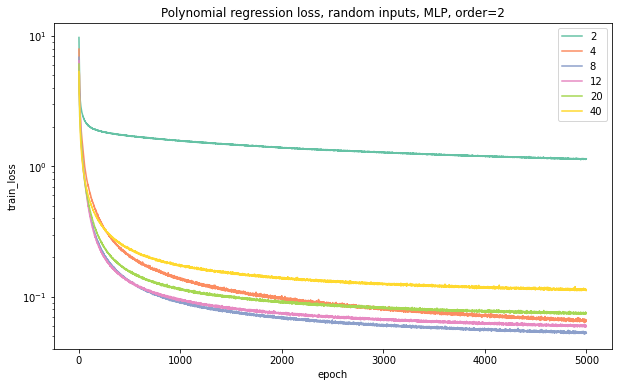

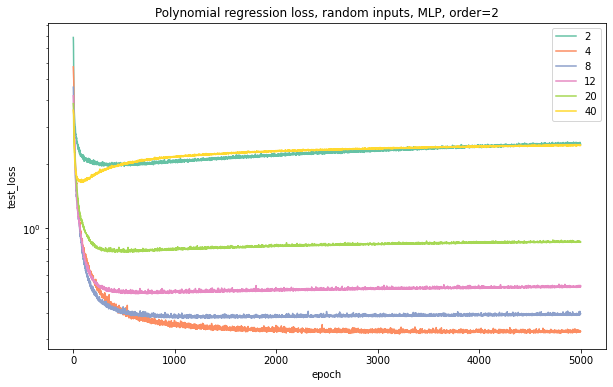

/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662707476.028768.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662714514.15584.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662700911.822541.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662700850.653939.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662707652.768647.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662700955.35254.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_4_numexamples_50000_is_online_

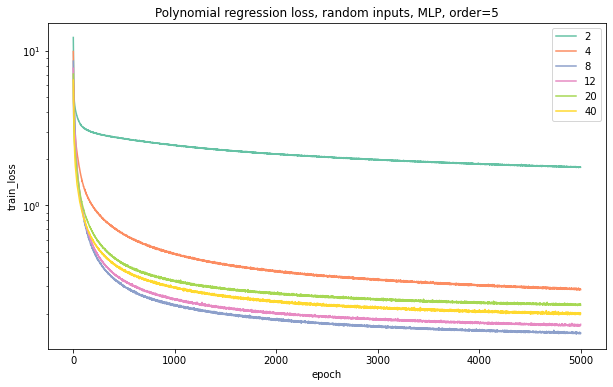

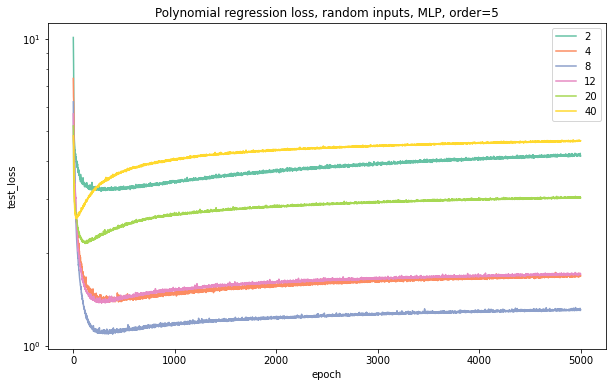

/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662707529.400394.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662707979.578001.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662714450.92583.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_4_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662707555.876422.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662700971.05094.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662714718.371119.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_2_numexamples_50000_is_on

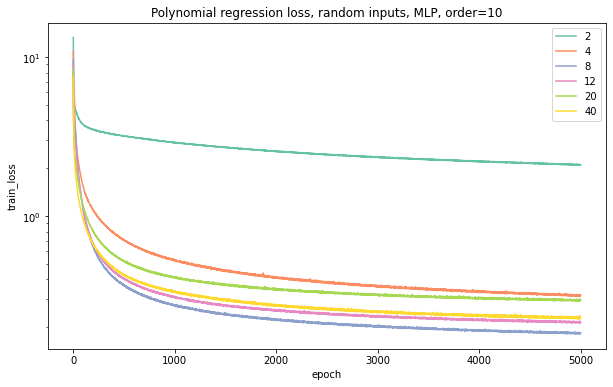

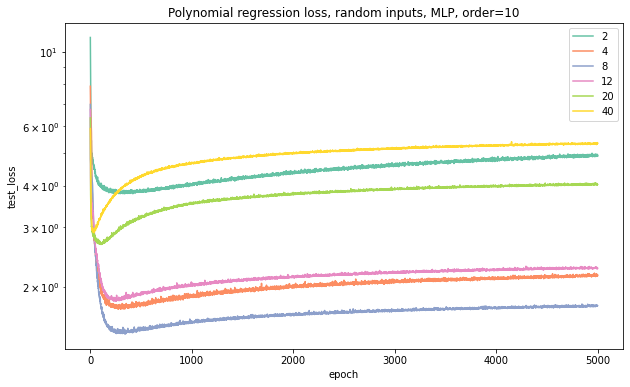

In [31]:
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_examples_list = [],
               pe_weight_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_examples"] not in num_examples_list:
            continue
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        
        pars["train_loss"].extend(record["metrics"]["train_loss_prog"])
        pars["test_loss"].extend(record["metrics"]["test_loss_prog"])
        pars["epoch"].extend(range(len(record["metrics"]["train_loss_prog"])))
        pars["policy"].extend([(record["data_params"]["num_inputs"])] * len(record["metrics"]["train_loss_prog"]))
        print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="train_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="test_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1)
    plt.title(title)
    plt.show()
    
get_record(model_name = "mlp_small", order = 2, input_strategy_list=["random"], 
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, order=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "mlp_small", order = 5, input_strategy_list=["random"], 
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, order=5", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "mlp_small", order = 10, input_strategy_list=["random"], 
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, order=10", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")

/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_20_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662739520.575269.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662721410.67581.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662721531.121621.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_4_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662721410.67911.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662738773.956107.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_40_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662721590.914685.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_2_numinputs_12_numexamples_150000_is_o

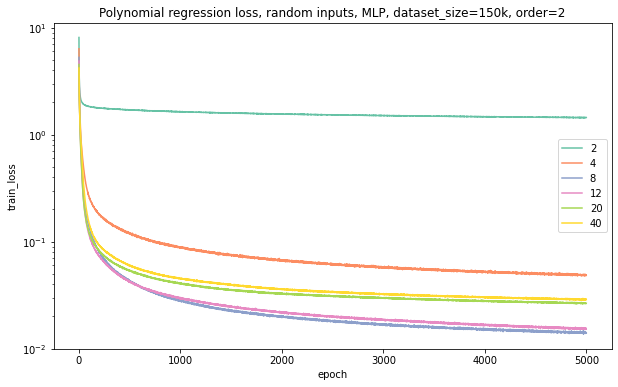

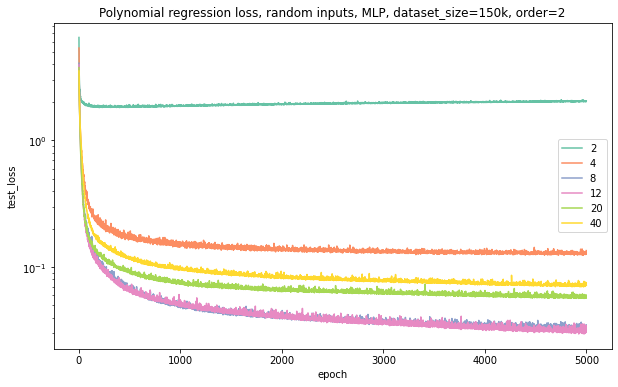

/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662718809.954504.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662737760.525819.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662737316.2151.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_20_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662738201.094543.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662720690.480012.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_4_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662737458.976362.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_5_numinputs_40_numexamples_150000_is_on

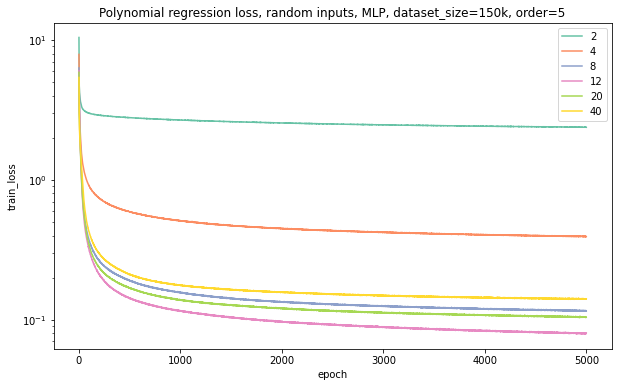

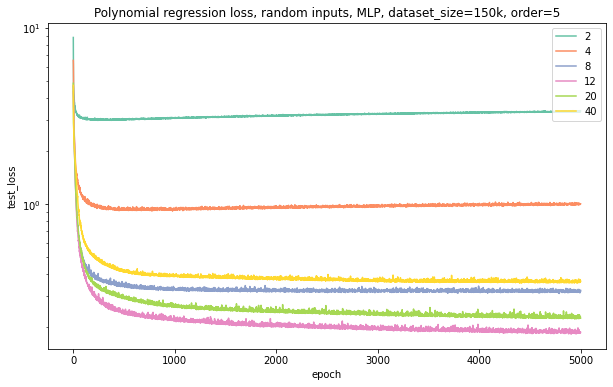

/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662701030.350261.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662718768.33673.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_20_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662701030.843413.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662739721.9851.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_20_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662739025.86817.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1662701000.470395.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_small_order_10_numinputs_2_numexamples_150000

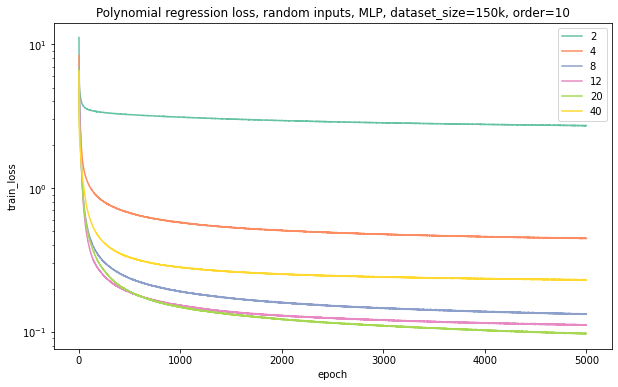

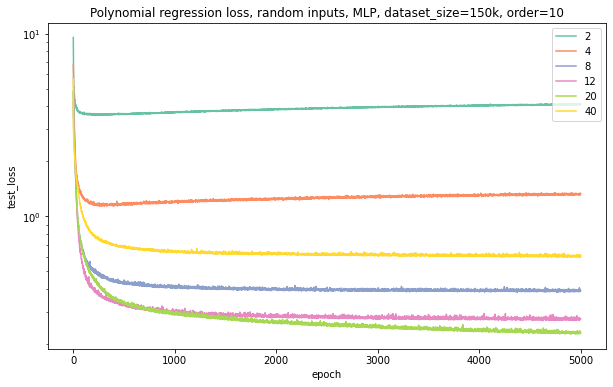

In [32]:
get_record(model_name = "mlp_small", order = 2, input_strategy_list=["random"], 
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, dataset_size=150k, order=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "mlp_small", order = 5, input_strategy_list=["random"], 
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, dataset_size=150k, order=5", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "mlp_small", order = 10, input_strategy_list=["random"], 
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, dataset_size=150k, order=10", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")

/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_2_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662736605.714957.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_2_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662737154.544075.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_2_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662729708.033183.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_2_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662737286.858098.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_2_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662737474.225041.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_2_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662721862.480645.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_2_numinputs_2_numexamples_50000_is_online

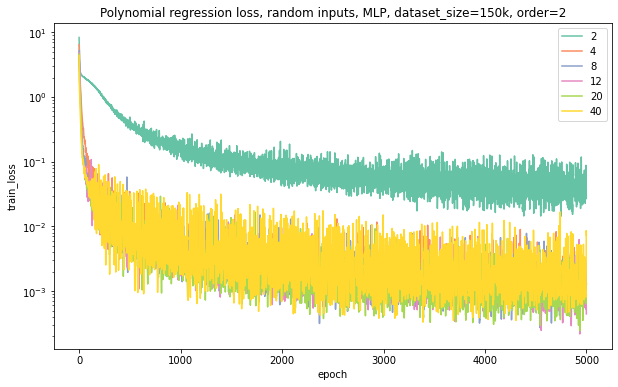

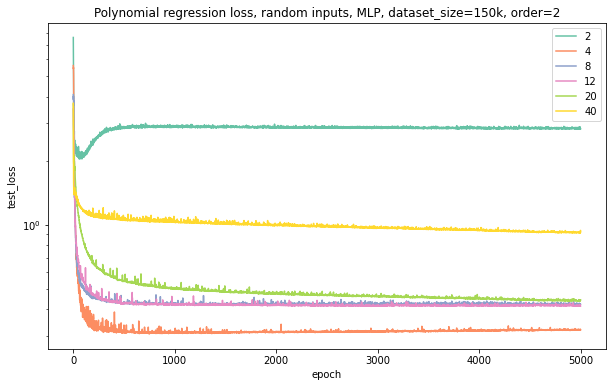

/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_5_numinputs_4_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662751413.085291.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_5_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662722680.347041.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_5_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662744950.197873.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_5_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662730383.776404.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_5_numinputs_4_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662744196.531927.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_5_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662744919.962048.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_5_numinputs_40_numexamples_50000_is_online_F

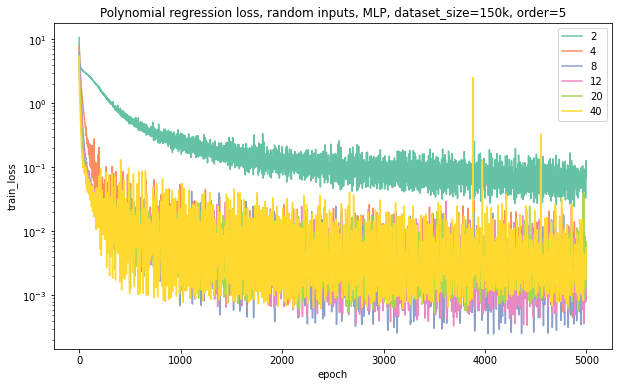

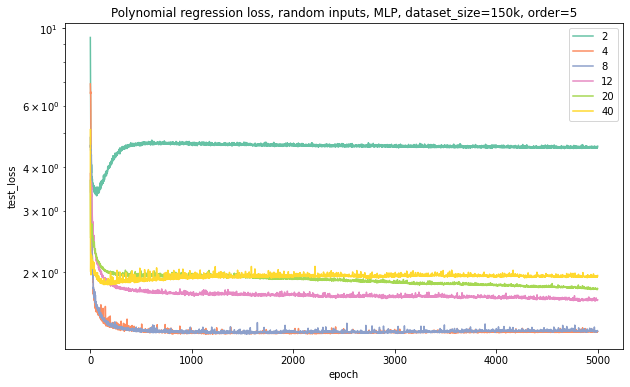

/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_10_numinputs_4_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662746500.636998.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/mlp_large_order_10_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1662745310.888599.pkl noise 0.0


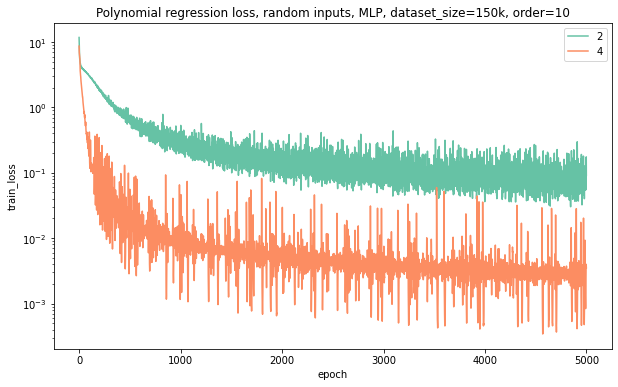

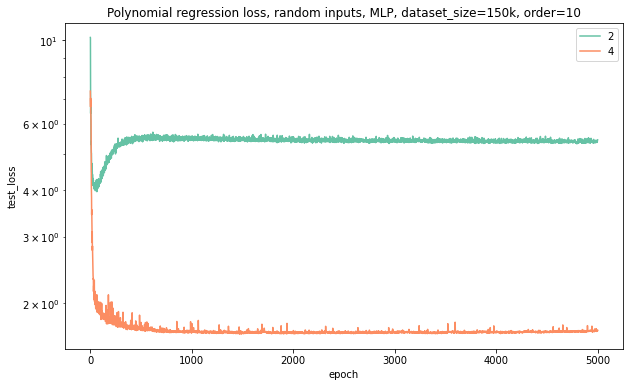

In [33]:
get_record(model_name = "mlp_large", order = 2, input_strategy_list=["random"], 
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, dataset_size=150k, order=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "mlp_large", order = 5, input_strategy_list=["random"], 
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, dataset_size=150k, order=5", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "mlp_large", order = 10, input_strategy_list=["random"], 
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, dataset_size=150k, order=10", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")

ValueError: Could not interpret value `epoch` for parameter `x`

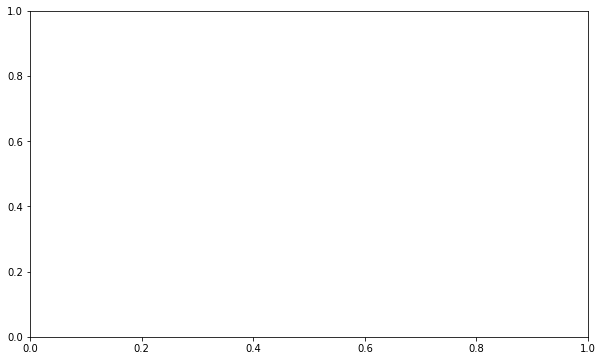

In [34]:
get_record(model_name = "mlp_large", order = 2, input_strategy_list=["random"], 
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, position encoding, order=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "mlp_large", order = 5, input_strategy_list=["random"], 
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, position encoding, order=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "mlp_large", order = 10, input_strategy_list=["random"], 
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, position encoding, order=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")

In [10]:
import utils
dat = utils.load_file_pickle("./random_sorted_data.pkl")

In [11]:
xs = torch.stack([x for x in list(zip(*dat))][0])

In [34]:
hs = []
for inds in xs.T[:20]:
    hs.append(torch.histogram(inds,bins=torch.linspace(-1,1,51), density=True))
hist = torch.stack([h[0] for h in hs])
hs = []
for inds in xs.T[20:]:
    hs.append(torch.histogram(inds,bins=torch.linspace(-20,20,51), density=True))
yhist = torch.stack([h[0] for h in hs])

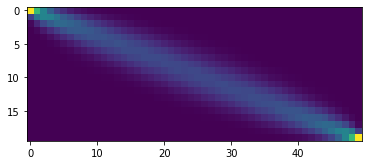

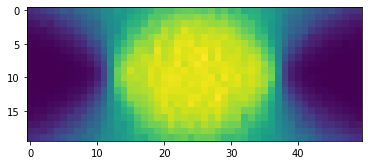

In [41]:
plt.imshow(hist)
# plt.xticks(ticks=torch.arange(0,51,9),labels=np.linspace(-1,1,6))
plt.show()
plt.imshow(yhist)
plt.show()

/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663537490.340852.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663537492.89641.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_40_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663551443.361433.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663550424.554344.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_8_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663551105.715962.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663543902.103503.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_a

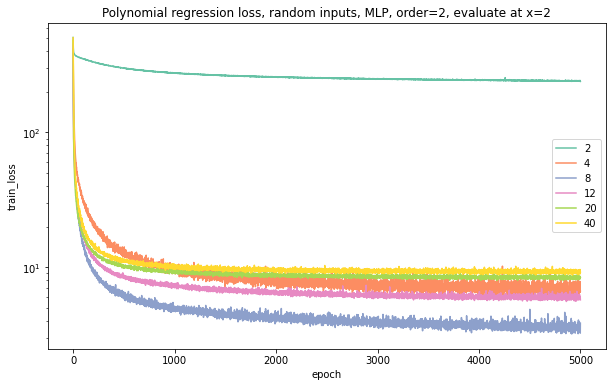

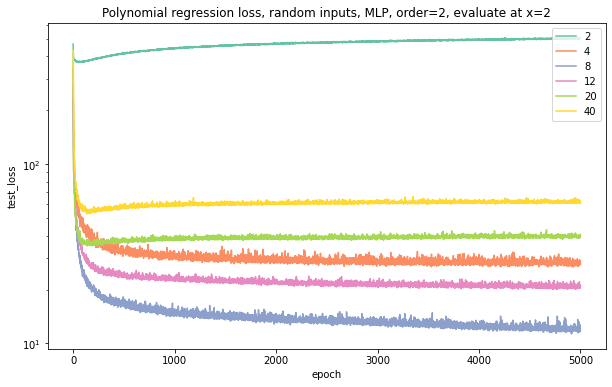

/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663537564.608078.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663543880.300945.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_12_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663551272.75634.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_2_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663543688.305074.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_20_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663537577.791083.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_4_numexamples_50000_is_online_False_num_inputs_kept_0_rep_1663550414.708868.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_a

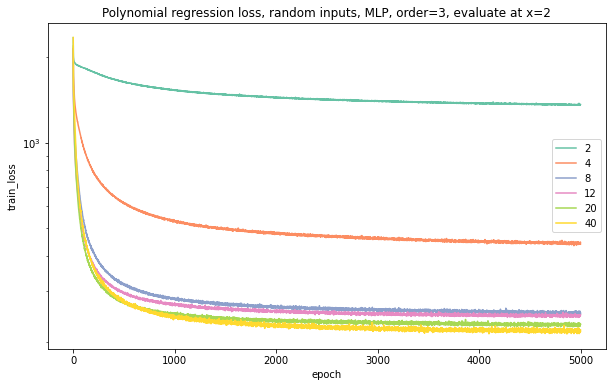

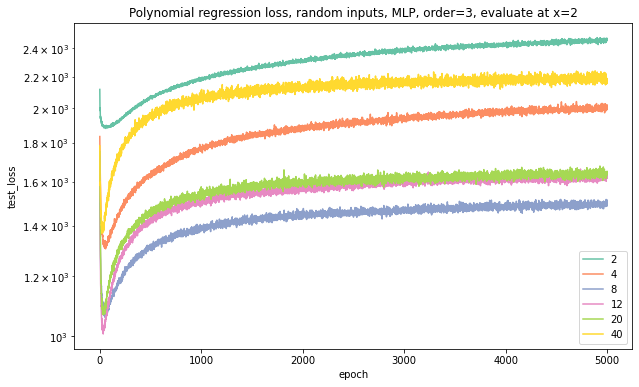

/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663537684.477455.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_4_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663555669.458592.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663537684.734247.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663554919.518256.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663537687.472856.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_2_numinputs_40_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663555473.880653.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_eva

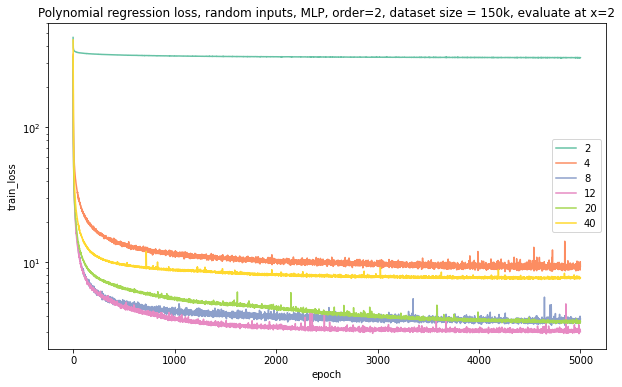

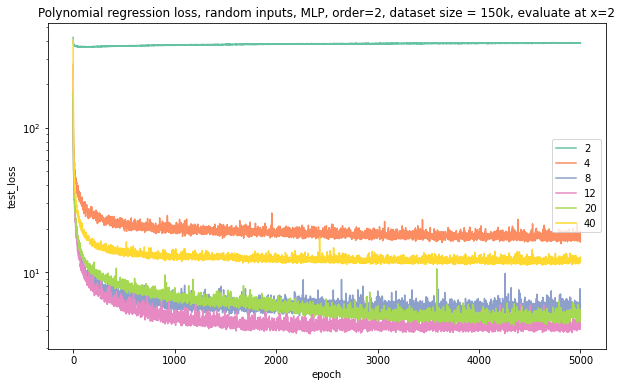

/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663537578.935118.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_40_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663593973.776442.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_20_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663537592.508893.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_40_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663537592.52801.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663573375.693704.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_evaluate_at_2/mlp_small_order_3_numinputs_40_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663574945.216018.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_eva

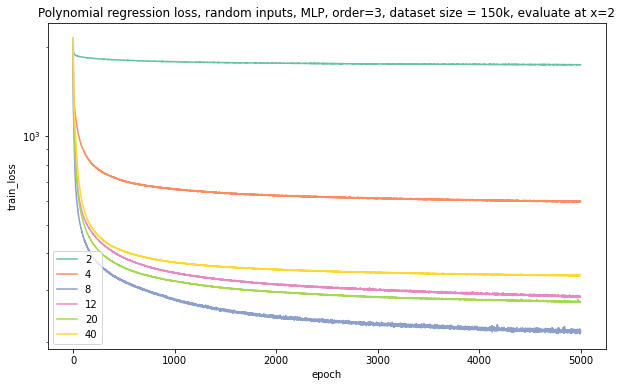

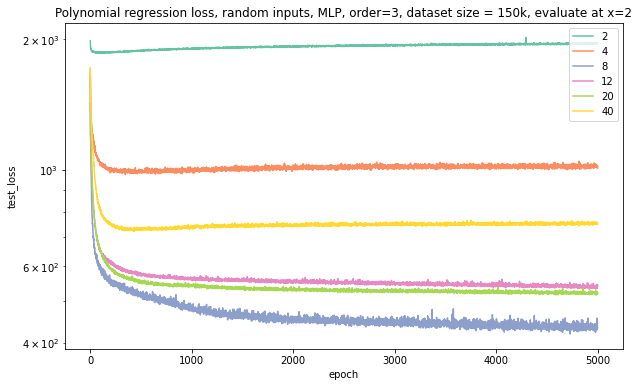

In [45]:
import warnings
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_examples_list = [],
               pe_weight_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_examples"] not in num_examples_list:
            continue
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        
        pars["train_loss"].extend(record["metrics"]["train_loss_prog"])
        pars["test_loss"].extend(record["metrics"]["test_loss_prog"])
        pars["epoch"].extend(range(len(record["metrics"]["train_loss_prog"])))
        pars["policy"].extend([(record["data_params"]["num_inputs"])] * len(record["metrics"]["train_loss_prog"]))
        print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="train_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="test_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1)
    plt.title(title)
    plt.show()
    
get_record(model_name = "mlp_small", order = 2, input_strategy_list=["random"], 
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, order=2, evaluate at x=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_evaluate_at_2")
get_record(model_name = "mlp_small", order = 3, input_strategy_list=["random"], 
           num_examples_list = [50000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, order=3, evaluate at x=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_evaluate_at_2")
get_record(model_name = "mlp_small", order = 2, input_strategy_list=["random"], 
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, order=2, dataset size = 150k, evaluate at x=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_evaluate_at_2")
get_record(model_name = "mlp_small", order = 3, input_strategy_list=["random"], 
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, MLP, order=3, dataset size = 150k, evaluate at x=2", 
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_evaluate_at_2")



/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557601.851563.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_4_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557450.201166.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557360.492494.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557631.224945.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_20_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557691.268491.pkl noise 0.0


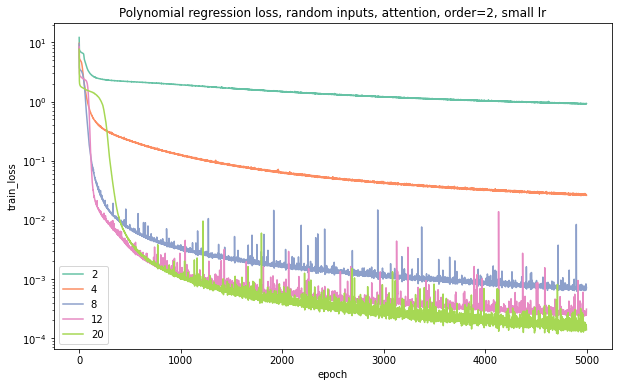

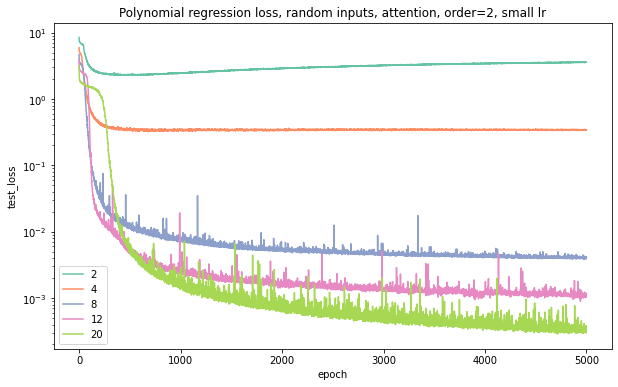

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557601.851563.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_4_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557450.201166.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557360.492494.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557631.224945.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_20_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557691.268491.pkl noise 0.0


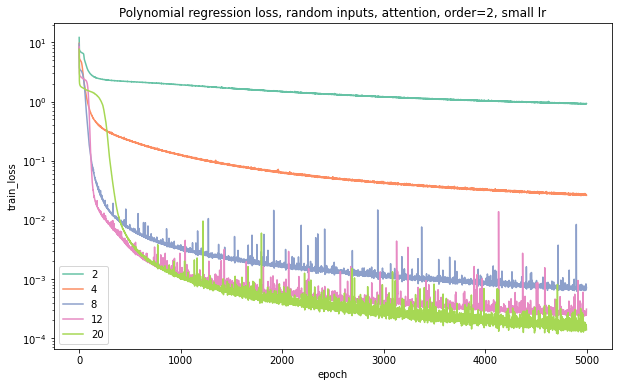

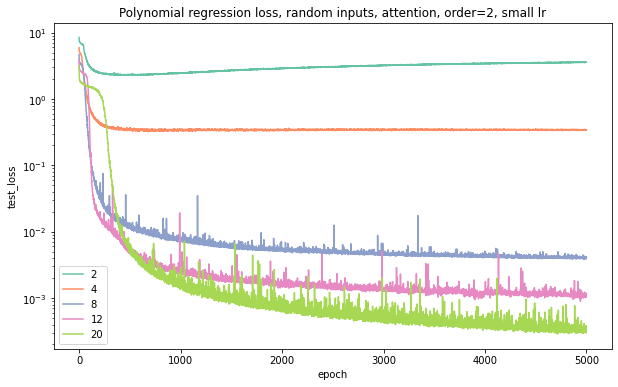

/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_8_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557601.851563.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_4_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557450.201166.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_2_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557360.492494.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_12_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557631.224945.pkl noise 0.0
/scratch/gpfs/qanguyen/poly_attn/attention_small_order_3_numinputs_20_numexamples_150000_is_online_False_num_inputs_kept_0_rep_1663557691.268491.pkl noise 0.0


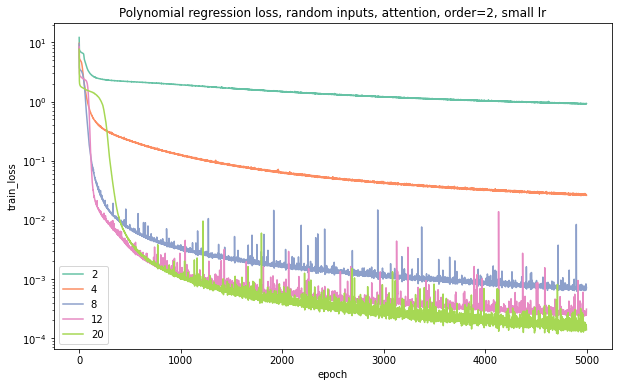

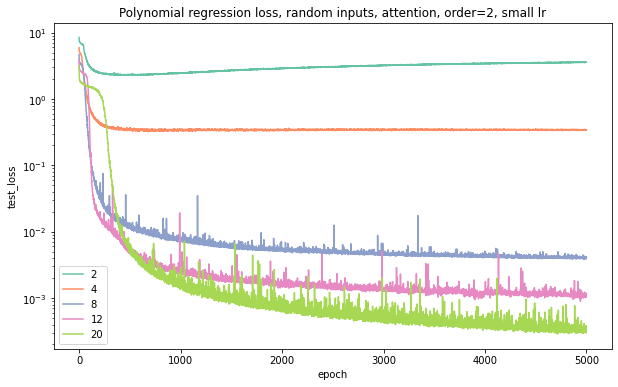

In [51]:
import warnings
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_examples_list = [], lr_list=[],
               pe_weight_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["num_examples"] not in num_examples_list:
            continue
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        if record["model_optim_params"]["optimizer"].param_groups[0]['lr'] not in lr_list:
             continue
        
        pars["train_loss"].extend(record["metrics"]["train_loss_prog"])
        pars["test_loss"].extend(record["metrics"]["test_loss_prog"])
        pars["epoch"].extend(range(len(record["metrics"]["train_loss_prog"])))
        pars["policy"].extend([(record["data_params"]["num_inputs"])] * len(record["metrics"]["train_loss_prog"]))
        print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="train_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="test_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1)
    plt.title(title)
    plt.show()
    
get_record(model_name = "attention_small", order = 3, input_strategy_list=["random"], 
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, order=2, small lr", 
           lr_list = [0.5e-4],
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 3, input_strategy_list=["random"], 
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, order=2, small lr", 
           lr_list = [0.5e-4],
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 3, input_strategy_list=["random"], 
           num_examples_list = [150000],
           is_online=False, title = "Polynomial regression loss, random inputs, attention, order=2, small lr", 
           lr_list = [0.5e-4],
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")



ValueError: Could not interpret value `epoch` for parameter `x`

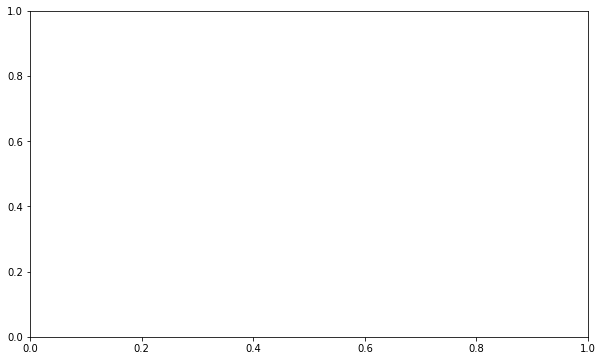

In [53]:
import warnings
def get_record(model_name, order, is_online, extra = "", title = None, num_inputs_list = [], 
               num_examples_list = [], lr_list=[],
               pe_weight_list = [],
               input_strategy_list=[], outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*"):
        
        try:
            record = utils.load_file_pickle(f)
            
        except Exception as e: 
            print(e)
        if record["data_params"]["is_online"] not in is_online:
            continue
        if record["data_params"]["num_examples"] not in num_examples_list:
            continue
        if record["data_params"]["num_inputs"] not in num_inputs_list:
             continue
        if record["data_params"]["input_strategy"] not in input_strategy_list:
             continue
        if record["model_optim_params"]["optimizer"].param_groups[0]['lr'] not in lr_list:
             continue
        
        pars["train_loss"].extend(record["metrics"]["train_loss_prog"])
        pars["test_loss"].extend(record["metrics"]["test_loss_prog"])
        pars["epoch"].extend(range(len(record["metrics"]["train_loss_prog"])))
        pars["policy"].extend([(record["data_params"]["num_inputs"])] * len(record["metrics"]["train_loss_prog"]))
        print(f, "noise", record["data_params"]["noise"])
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="train_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="test_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1)
    plt.title(title)
    plt.show()
    
get_record(model_name = "attention_small", order = 3, input_strategy_list=["random"], 
           num_examples_list = [50000],
           is_online=[True], title = "Polynomial regression loss, random inputs, attention, order=2, small lr", 
           lr_list = [0.5e-4,0.5e-3],
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 3, input_strategy_list=["random"], 
           num_examples_list = [50000],
           is_online=[True], title = "Polynomial regression loss, random inputs, attention, order=2, small lr", 
           lr_list = [0.5e-4,0.5e-3],
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")
get_record(model_name = "attention_small", order = 3, input_strategy_list=["random"], 
           num_examples_list = [50000],
           is_online=[True], title = "Polynomial regression loss, random inputs, attention, order=2, small lr", 
           lr_list = [0.5e-4,0.5e-3],
           num_inputs_list=[2, 4,8,12,20, 40, 60], 
           outdir = "/scratch/gpfs/qanguyen/poly_attn")



## Noise

In [25]:
importlib.reload(utils)
def get_record(model_name, order, is_online, extra = "", title = None, 
               order_list = [], noise_list = [],
               outdir = "/scratch/gpfs/qanguyen/poly1/"):
    # outdir = "/gpfs/milgram/scratch60/turk-browne/an633/poly"
    warnings.filterwarnings(action='once')
    pars = defaultdict(list)
    
    for f in glob.glob(f"{outdir}/{model_name}_order_{order}_*_is_online_{is_online}_*"):
        print(f)
        
        record = utils.load_file_pickle(f)
        if record["data_params"]["num_inputs"] not in order_list:
             continue
        if record["data_params"]["noise"] not in noise_list:
            continue
        pars["train_loss"].extend(record["metrics"]["train_loss_prog"])
        pars["test_loss"].extend(record["metrics"]["test_loss_prog"])
        pars["epoch"].extend(range(len(record["metrics"]["train_loss_prog"])))
        pars["policy"].extend([(record["data_params"]["num_inputs"])] * len(record["metrics"]["train_loss_prog"]))

    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="train_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1.5)
    plt.title(title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x = "epoch", y="test_loss", hue = "policy", palette = "Set2", data=pars, ci=None)
    ax.set(yscale="log")
    plt.legend()
    #plt.ylim(0.5e-3, 1)
    plt.title(title)
    plt.show()
    
import warnings


/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_80_numexamples_50000_is_online_False_rep_1660448081.383974.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_4_numexamples_50000_is_online_False_rep_1660480137.354691.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_20_numexamples_50000_is_online_False_rep_1660461795.745184.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_4_numexamples_50000_is_online_False_rep_1660473487.961765.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_2_numexamples_50000_is_online_False_rep_1660454205.619352.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_12_numexamples_50000_is_online_False_rep_1660493174.530665.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_60_numexamples_50000_is_online_False_rep_1660505233.522593.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_12_numexamples_50000_is_online_False_rep_1660486799.028931.pkl
/sc

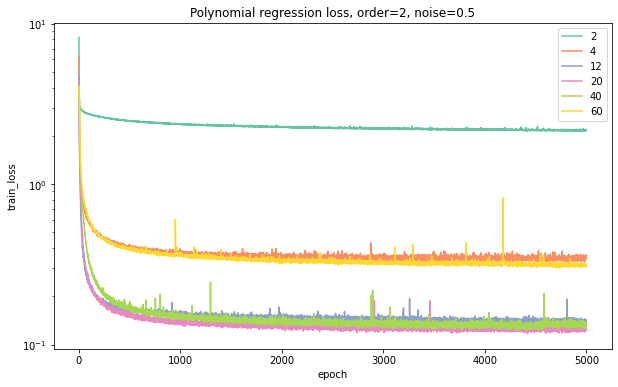

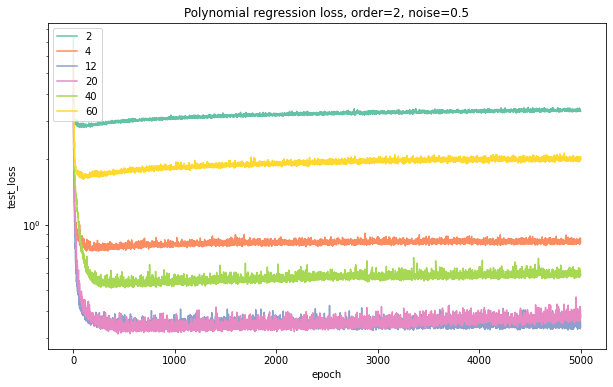

/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_80_numexamples_50000_is_online_False_rep_1660448081.383974.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_4_numexamples_50000_is_online_False_rep_1660480137.354691.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_20_numexamples_50000_is_online_False_rep_1660461795.745184.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_4_numexamples_50000_is_online_False_rep_1660473487.961765.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_2_numexamples_50000_is_online_False_rep_1660454205.619352.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_12_numexamples_50000_is_online_False_rep_1660493174.530665.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_60_numexamples_50000_is_online_False_rep_1660505233.522593.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_2_numinputs_12_numexamples_50000_is_online_False_rep_1660486799.028931.pkl
/sc

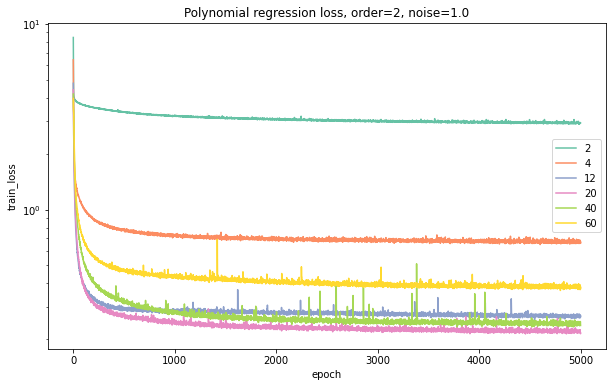

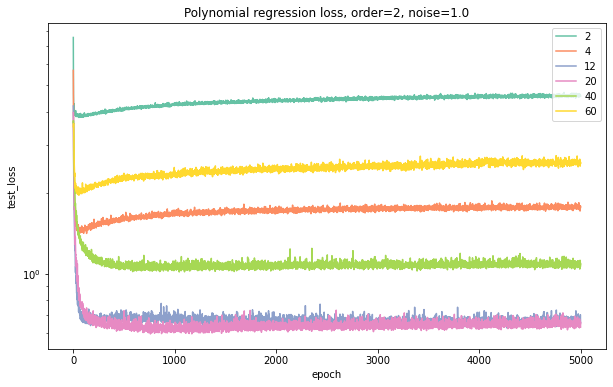

/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_2_numexamples_50000_is_online_False_rep_1660587508.15507.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_20_numexamples_50000_is_online_False_rep_1660587616.633156.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_8_numexamples_50000_is_online_False_rep_1660587508.236121.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_4_numexamples_50000_is_online_False_rep_1660587621.874653.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_60_numexamples_50000_is_online_False_rep_1660587621.883807.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_60_numexamples_50000_is_online_False_rep_1660587677.557184.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_20_numexamples_50000_is_online_False_rep_1660587677.677067.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_4_numexamples_50000_is_online_False_rep_1660587628.913662.pkl
/scra

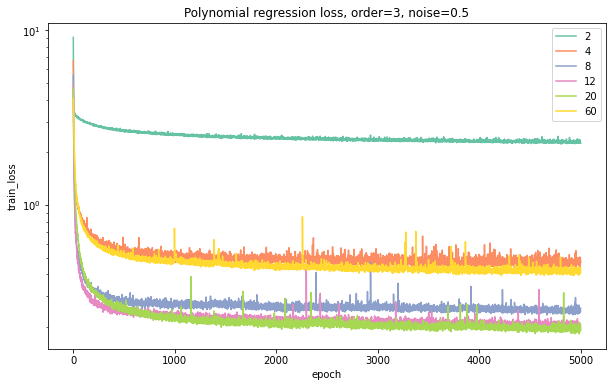

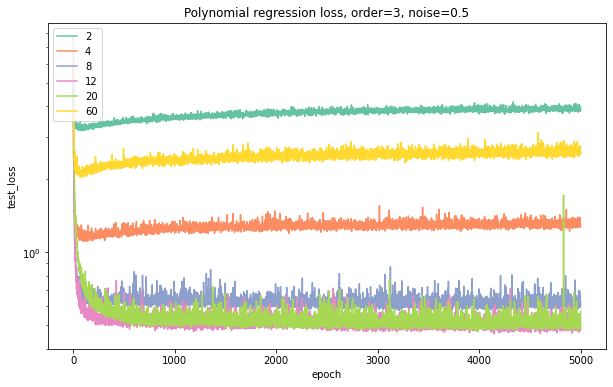

/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_2_numexamples_50000_is_online_False_rep_1660587508.15507.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_20_numexamples_50000_is_online_False_rep_1660587616.633156.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_8_numexamples_50000_is_online_False_rep_1660587508.236121.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_4_numexamples_50000_is_online_False_rep_1660587621.874653.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_60_numexamples_50000_is_online_False_rep_1660587621.883807.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_60_numexamples_50000_is_online_False_rep_1660587677.557184.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_20_numexamples_50000_is_online_False_rep_1660587677.677067.pkl
/scratch/gpfs/qanguyen/poly_noise/mlp_small_order_3_numinputs_4_numexamples_50000_is_online_False_rep_1660587628.913662.pkl
/scra

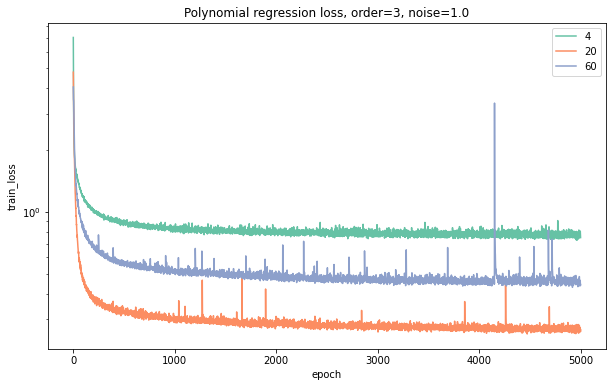

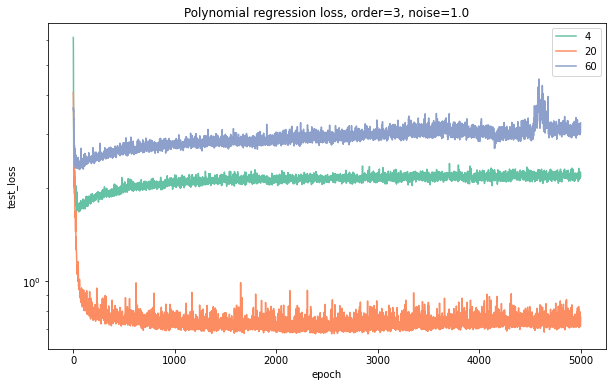

In [29]:
get_record(model_name = "mlp_small", order = 2, is_online=False, title = "Polynomial regression loss, order=2, noise=0.5", order_list=[2, 4,8,12,20, 40, 60], noise_list = [0.5], outdir = "/scratch/gpfs/qanguyen/poly_noise/")
get_record(model_name = "mlp_small", order = 2, is_online=False, title = "Polynomial regression loss, order=2, noise=1.0", order_list=[2, 4,8,12,20, 40, 60], noise_list = [1.0], outdir = "/scratch/gpfs/qanguyen/poly_noise/")
get_record(model_name = "mlp_small", order = 3, is_online=False, title = "Polynomial regression loss, order=3, noise=0.5", order_list=[2, 4,8,12,20, 40, 60], noise_list = [0.5], outdir = "/scratch/gpfs/qanguyen/poly_noise/")
get_record(model_name = "mlp_small", order = 3, is_online=False, title = "Polynomial regression loss, order=3, noise=1.0", order_list=[2, 4,8,12,20, 40, 60], noise_list = [1.0], outdir = "/scratch/gpfs/qanguyen/poly_noise/")
